In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-wordnet-python3/awn.xml
/kaggle/input/arabic-wordnet-python3/AWNDatabaseManagement.py
/kaggle/input/arabic-classification/arabic_dataset_classifiction.csv/arabic_dataset_classifiction.csv


## Setup & Hyperparameter Configuration

In [2]:
# =========================
# Cell 1: Setup & Config
# =========================

import warnings

# Hide only FutureWarning messages
warnings.filterwarnings("ignore")

import sys, subprocess, os, platform

def pip_install(pkg_spec):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg_spec])
    except Exception as e:
        print(f"Warning installing {pkg_spec}: {e}")

# Install packages
# pip_install("tensorflow==2.15.0")
pip_install("transformers>=4.40,<4.43")
pip_install("datasets>=2.19.0")
pip_install("scikit-learn>=1.4.0,<1.6")
pip_install("nltk>=3.8.1")
pip_install("pyarabic>=0.6.15")

# Imports
import tensorflow as tf
import numpy as np, random, pandas as pd
import transformers, sklearn, nltk, pyarabic
import matplotlib.pyplot as plt

# Show versions
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("Transformers:", transformers.__version__)
print("scikit-learn:", sklearn.__version__)
print("NLTK:", nltk.__version__)
print("PyArabic:", pyarabic.__version__ if hasattr(pyarabic, "__version__") else "ok")
print("Platform:", platform.platform())

# Download NLTK resources
nltk.download("stopwords", quiet=True)

# Seeds
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Configuration dictionary
CONFIG = {
    "MAX_LEN": 120,
    "NUM_CLASSES": 5,
    "TFIDF_MAX_FEATURES": 1000,
    "BOW_MAX_FEATURES": 1000,
    "EMBED_DIM": 256,
    "NUM_HEADS": 2,
    "FF_DIM": 256,
    "GRU_UNITS": 256,
    "LSTM_UNITS": 128,
    "DENSE_UNITS": 64,
    "DROPOUT": 0.1,
    "OPTIMIZER": "Nadam",
    "BATCH_SIZE": 16,
    "EPOCHS": 10,
    "EARLY_STOPPING_PATIENCE": 3,
    "BERT_TOKENIZER_NAME": "asafaya/bert-base-arabic",
}

# Convert CONFIG to DataFrame
config_df = pd.DataFrame(CONFIG.items(), columns=["Parameter", "Value"])

# Display as table
print("\n==== CONFIG (from paper) ====")
display(config_df)

# Save as CSV
csv_path = "/kaggle/working/config_table.csv"
config_df.to_csv(csv_path, index=False)
print(f"Config saved to CSV: {csv_path}")

# Save as PNG
png_path = "/kaggle/working/config_table.png"
fig, ax = plt.subplots(figsize=(8, len(config_df)*0.4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=config_df.values,
                 colLabels=config_df.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"Config saved to PNG: {png_path}")

# GPU check
print("\nGPUs:", tf.config.list_physical_devices('GPU'))

# Dataset paths in Kaggle
KAGGLE_INPUT_DIRS = [
    "/kaggle/input/arabic-classification",
    "/kaggle/working/dataset",
]
print("\nDataset search paths:", KAGGLE_INPUT_DIRS)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 987.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system ==

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 93.0 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
2025-10-06 11:02:51.625861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759748572.021282      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759748572.129599      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0
Transformers: 4.42.4
scikit-learn: 1.5.2
NLTK: 3.9.1
PyArabic: ok
Platform: Linux-6.6.56+-x86_64-with-glibc2.35

==== CONFIG (from paper) ====


,Parameter,Value
0,MAX_LEN,120
1,NUM_CLASSES,5
2,TFIDF_MAX_FEATURES,1000
3,BOW_MAX_FEATURES,1000
4,EMBED_DIM,256
5,NUM_HEADS,2
6,FF_DIM,256
7,GRU_UNITS,256
8,LSTM_UNITS,128
9,DENSE_UNITS,64


Config saved to CSV: /kaggle/working/config_table.csv
Config saved to PNG: /kaggle/working/config_table.png

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

Dataset search paths: ['/kaggle/input/arabic-classification', '/kaggle/working/dataset']


## Load Dataset & EDA (Section III)

CSV path: /kaggle/input/arabic-classification/arabic_dataset_classifiction.csv/arabic_dataset_classifiction.csv
AWN dir: /kaggle/input
AWN Python: /kaggle/input/arabic-wordnet-python3/AWNDatabaseManagement.py
AWN XML: /kaggle/input/arabic-wordnet-python3/awn.xml
Shape: (111728, 2)
Columns: ['text', 'targe']
Using TEXT_COL: text | LABEL_COL: targe

=== Dataset Statistics ===


,Class ID,Count,Percent
0,0,13736,12.63
1,1,16728,15.38
2,2,14165,13.02
3,3,20485,18.83
4,4,43675,40.15


,Value
Statistic,
count,108789.00
mean,261.37
std,207.49
min,1.00
50%,210.00
75%,331.00
90%,478.00
95%,619.00
max,5049.00


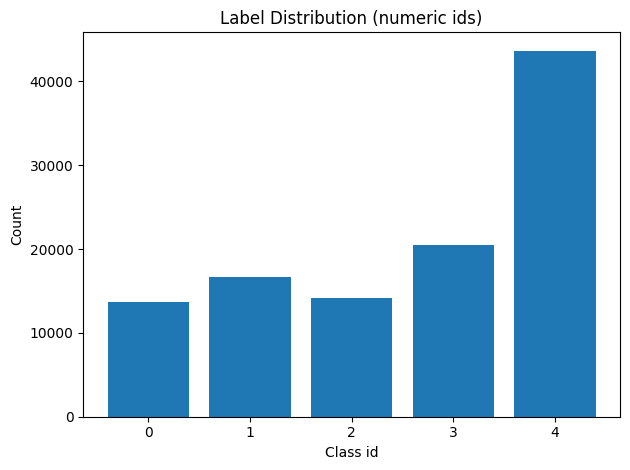

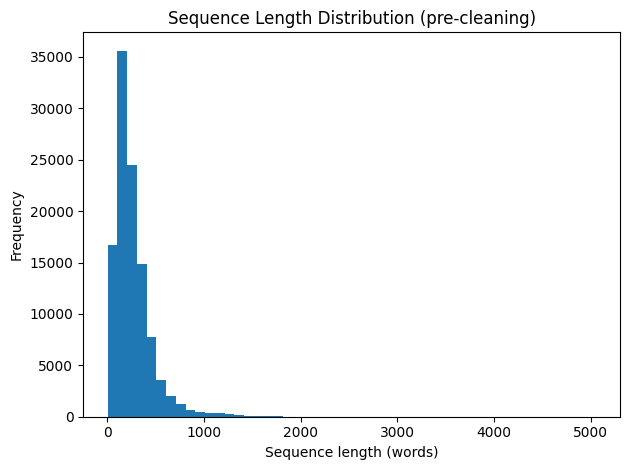


Saved DATA_META: {
  "csv_path": "/kaggle/input/arabic-classification/arabic_dataset_classifiction.csv/arabic_dataset_classifiction.csv",
  "text_col": "text",
  "label_col": "targe",
  "label_id_order": [
    0,
    1,
    2,
    3,
    4
  ],
  "awn_dir": "/kaggle/input",
  "awn_py": "/kaggle/input/arabic-wordnet-python3/AWNDatabaseManagement.py",
  "awn_xml": "/kaggle/input/arabic-wordnet-python3/awn.xml"
}


In [3]:
# =========================
# Cell 2: Load Dataset & EDA (Section III)
# - Explicitly use columns: 'text' and 'targe' (0..4)
# - Show label distribution and sequence-length distribution (pre-cleaning)
# - Locate Arabic WordNet (AWN) assets for later augmentation
# =========================

import os, re, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Expected dataset and AWN directories ----------
CANDIDATE_DATA_DIRS = [
    "/kaggle/input/arabic-classification",
    "/kaggle/input/DATASETS/arabic-classification",
    "/kaggle/input",
]
CANDIDATE_AWN_DIRS = [
    "/kaggle/input/arabic-wordnet",
    "/kaggle/input/DATASETS/arabic-wordnet",
    "/kaggle/input",
]

DATA_CSV_EXPECTED = "arabic_dataset_classifiction.csv"
CSV_FALLBACK_PATTERNS = [r"classific.*\.csv", r"arabic_.*class.*\.csv"]

def find_file(root_dirs, preferred_name, patterns):
    """Find dataset file by exact name first, then by regex patterns."""
    for rd in root_dirs:
        p = os.path.join(rd, preferred_name)
        if os.path.isfile(p):
            return p
    for rd in root_dirs:
        for root, _, files in os.walk(rd):
            for fn in files:
                for pat in patterns:
                    if re.search(pat, fn, flags=re.IGNORECASE):
                        return os.path.join(root, fn)
    return None

def find_dir(root_dirs, must_include_files=None):
    """Find AWN directory, optionally verifying required files."""
    for rd in root_dirs:
        if not os.path.isdir(rd):
            continue
        if not must_include_files:
            return rd
        files = set(os.listdir(rd))
        if all(any(re.fullmatch(pat, f) for f in files) for pat in must_include_files):
            return rd
    for base in root_dirs:
        for root, dirs, files in os.walk(base):
            if not must_include_files:
                return root
            file_set = set(files)
            if all(any(re.fullmatch(pat, f) for f in file_set) for pat in must_include_files):
                return root
    return None

# Locate dataset CSV
DATA_CSV_PATH = find_file(CANDIDATE_DATA_DIRS, DATA_CSV_EXPECTED, CSV_FALLBACK_PATTERNS)
if DATA_CSV_PATH is None:
    raise FileNotFoundError("Dataset CSV not found. Attach the 'arabic-classification' dataset.")

# Locate AWN directory and files
AWN_DIR = find_dir(CANDIDATE_AWN_DIRS)
AWN_PY, AWN_XML = None, None
if AWN_DIR:
    for root, _, files in os.walk(AWN_DIR):
        for fn in files:
            if fn.lower() == "awndatabasemanagement.py":
                AWN_PY = os.path.join(root, fn)
            if fn.lower().endswith(".xml") and "awn" in fn.lower():
                AWN_XML = os.path.join(root, fn)

print("CSV path:", DATA_CSV_PATH)
print("AWN dir:", AWN_DIR)
print("AWN Python:", AWN_PY)
print("AWN XML:", AWN_XML)

# ---------- Robust CSV reader (handles BOM and encodings) ----------
def read_csv_safely(path):
    last_err = None
    for enc in ["utf-8", "utf-8-sig", "cp1256", "latin-1"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e
    raise last_err

df = read_csv_safely(DATA_CSV_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# ---------- Explicit column mapping ----------
if "text" not in df.columns:
    raise ValueError("Expected a 'text' column in the CSV.")
if "targe" not in df.columns and "target" not in df.columns:
    raise ValueError("Expected a 'targe' (or 'target') column in the CSV.")

TEXT_COL = "text"
LABEL_COL = "targe" if "targe" in df.columns else "target"
print("Using TEXT_COL:", TEXT_COL, "| LABEL_COL:", LABEL_COL)

# ---------- Drop missing and enforce integer labels ----------
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
labels_numeric = pd.to_numeric(df[LABEL_COL], errors="coerce")
df = df[labels_numeric.notna()].reset_index(drop=True)
df["label_id"] = labels_numeric.dropna().astype(int).values

# ---------- Dataset stats (pre-cleaning, Section III) ----------
print("\n=== Dataset Statistics ===")
label_counts = df["label_id"].value_counts().sort_index()
final_ids = sorted(df["label_id"].unique().tolist())

# Table: class distribution
label_df = pd.DataFrame({
    "Class ID": label_counts.index,
    "Count": label_counts.values,
    "Percent": (label_counts.values / len(df) * 100).round(2)
})
display(label_df)
label_df.to_csv("/kaggle/working/label_distribution.csv", index=False)

# Table: sequence length statistics
seq_len = df[TEXT_COL].astype(str).str.split().map(len)
seq_stats = seq_len.describe(percentiles=[0.5, 0.75, 0.9, 0.95]).round(2)
seq_df = pd.DataFrame(seq_stats)
seq_df.columns = ["Value"]
seq_df.index.name = "Statistic"
display(seq_df)
seq_df.to_csv("/kaggle/working/sequence_length_stats.csv")

# ---------- Plots ----------
# 1) Label distribution (bar plot)
plt.figure()
plt.bar(label_counts.index, label_counts.values)
plt.xticks(label_counts.index)
plt.title("Label Distribution (numeric ids)")
plt.xlabel("Class id")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("/kaggle/working/label_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# 2) Sequence length distribution (histogram)
plt.figure()
plt.hist(seq_len, bins=50)
plt.title("Sequence Length Distribution (pre-cleaning)")
plt.xlabel("Sequence length (words)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("/kaggle/working/sequence_length_hist.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------- Save metadata for later ----------
DATA_META = {
    "csv_path": DATA_CSV_PATH,
    "text_col": TEXT_COL,
    "label_col": LABEL_COL,
    "label_id_order": final_ids,
    "awn_dir": AWN_DIR,
    "awn_py": AWN_PY,
    "awn_xml": AWN_XML,
}
print("\nSaved DATA_META:", json.dumps(DATA_META, ensure_ascii=False, indent=2))


## Text Cleaning (Section IV-A)

In [4]:
# =========================
# Cell 3: Text Cleaning (Section IV-A)
# =========================

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pyarabic.araby import strip_tashkeel, strip_tatweel

# Preconditions
if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found. Please run Cell 2 first.")
if 'TEXT_COL' not in globals() or 'LABEL_COL' not in globals():
    raise RuntimeError("TEXT_COL / LABEL_COL not found. Please run Cell 2 first.")

# Arabic stopwords (NLTK)
try:
    AR_STOPWORDS = set(stopwords.words('arabic'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    AR_STOPWORDS = set(stopwords.words('arabic'))

# Ensure wordnet resources for lemmatizer
lemmatizer = WordNetLemmatizer()
try:
    from nltk.corpus import wordnet as wn
    _ = wn.synsets('test')
except LookupError:
    import nltk
    nltk.download('wordnet')
    nltk.download('omw-1.4')

# Punctuation pattern (Arabic + ASCII)
AR_PUNCT = r"""!"#$%&'()*+,\-./:;<=>?@[\]^_`{|}~"""
AR_PUNCT += "«»…ـ،؛؟“”"  # common Arabic punctuation
PUNCT_REGEX = re.compile(f"[{re.escape(AR_PUNCT)}]")

# Whitespace normalization
WS_REGEX = re.compile(r"\s+")

# --- Arabic letter normalization (Section IV-A) ---
AR_NORMALIZATION_MAP = {
    "أ": "ا", "إ": "ا", "آ": "ا",
    "ى": "ي", "ی": "ي",
    "ؤ": "و", "ئ": "ي",
    "ة": "ه",
    "ـ": "",
}
AR_NORM_REGEX = re.compile("|".join(map(re.escape, AR_NORMALIZATION_MAP.keys())))

def normalize_arabic_letters(text: str) -> str:
    return AR_NORM_REGEX.sub(lambda m: AR_NORMALIZATION_MAP[m.group(0)], text)

def clean_arabic_text(text: str) -> str:
    if not isinstance(text, str):
        text = str(text) if text is not None else ""

    # 1) lowercase
    t = text.lower()
    # 2) normalize Arabic letters
    t = normalize_arabic_letters(t)
    # 3) remove diacritics & tatweel
    t = strip_tashkeel(t)
    t = strip_tatweel(t)
    # 4) remove punctuation
    t = PUNCT_REGEX.sub(" ", t)
    # normalize whitespace
    t = WS_REGEX.sub(" ", t).strip()
    # tokenize
    tokens = t.split()
    # 5) remove stopwords
    tokens = [w for w in tokens if w not in AR_STOPWORDS]
    # 6) lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

print("Cleaning texts (paper-aligned)...")
df['text_clean'] = df[TEXT_COL].astype(str).map(clean_arabic_text)

# Quick sanity checks
print("\nSample before/after cleaning:")
for i in range(min(3, len(df))):
    print(f"\n# Sample {i+1}")
    print("RAW   :", df.loc[i, TEXT_COL][:200].replace("\n", " "))
    print("CLEAN :", df.loc[i, 'text_clean'][:200])

# Sequence length stats after cleaning
seq_len_clean = df['text_clean'].str.split().map(len)
seq_stats_clean = seq_len_clean.describe(percentiles=[0.5, 0.75, 0.9, 0.95]).round(2)

# Convert to DataFrame for clean display
seq_stats_df = pd.DataFrame(seq_stats_clean)
seq_stats_df.columns = ["Value"]
seq_stats_df.index.name = "Statistic"

print("\nSequence length stats AFTER cleaning (words):")
display(seq_stats_df)

# Save stats table as CSV and PNG
csv_path = "/kaggle/working/sequence_length_stats_clean.csv"
png_path = "/kaggle/working/sequence_length_stats_clean.png"
seq_stats_df.to_csv(csv_path)
print(f"Saved stats to CSV: {csv_path}")

fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=seq_stats_df.values,
                 rowLabels=seq_stats_df.index,
                 colLabels=seq_stats_df.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"Saved stats table as PNG: {png_path}")

# Persist minimal structure for next steps
DF_COLS_TO_KEEP = [TEXT_COL, 'text_clean', LABEL_COL]
if 'label_id' in df.columns:
    DF_COLS_TO_KEEP.append('label_id')
df_clean = df[DF_COLS_TO_KEEP].copy()

CLEAN_META = {
    "stopwords_size": len(AR_STOPWORDS),
    "uses_lemmatizer": True,
    "punct_removed": True,
    "diacritics_removed": True,
    "normalized_letters": True,
}
print("\nCLEAN_META:", CLEAN_META)
print("df_clean shape:", df_clean.shape)


Cleaning texts (paper-aligned)...

Sample before/after cleaning:

# Sample 1
RAW   : بين أستوديوهات ورزازات وصحراء مرزوكة وآثار وليلي ثم الرباط والبيضاء انتهى المخرج المغربي سهيل بن بركة من تصوير مشاهد عمله السينمائي الجديد الذي خصصه لتسليط الضوء عن حياة الجاسوس الإسباني دومينغو باديا
CLEAN : استوديوهات ورزازات وصحراء مرزوكه واثار وليلي الرباط والبيضاء انتهي المخرج المغربي سهيل بن بركه تصوير مشاهد عمله السينمايي الجديد خصصه لتسليط الضوء حياه الجاسوس الاسباني دومينغو باديا عاش فتره القرن ال

# Sample 2
RAW   : قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر عملها على الفن بل عملت مع أحد المتخصصين لإطلاق نوع جديد من الشاي سيصبح متوفرا ابتداء من الشهر المقبل في سلسلة مقاهي ستاربكس ونقلت وسائل إعلام أمريكية عن رئ
CLEAN : قررت النجمه الامريكيه اوبرا وينفري الا يقتصر عملها علي الفن عملت احد المتخصصين لاطلاق نوع جديد الشاي سيصبح متوفرا ابتداء الشهر المقبل سلسله مقاهي ستاربكس ونقلت وسايل اعلام امريكيه رييس مجلس اداره ستار

# Sample 3
RAW   : أخبارنا المغربية الوزاني تصوير الشملالي ألهب النجم المغ

,Value
Statistic,
count,108789.00
mean,220.35
std,172.15
min,0.00
50%,178.00
75%,279.00
90%,400.00
95%,516.00
max,3984.00


Saved stats to CSV: /kaggle/working/sequence_length_stats_clean.csv
Saved stats table as PNG: /kaggle/working/sequence_length_stats_clean.png

CLEAN_META: {'stopwords_size': 701, 'uses_lemmatizer': True, 'punct_removed': True, 'diacritics_removed': True, 'normalized_letters': True}
df_clean shape: (108789, 4)


## Data Augmentation with Arabic WordNet (Section IV-B)

In [5]:
# =========================
# Cell 4: Data Augmentation with Arabic WordNet (Section IV-B)
# Paper-faithful + AWN/token normalization alignment
# =========================

import os
import re
import xml.etree.ElementTree as ET
import numpy as np
import random

# --- Preconditions ---
if 'AWN_XML' not in globals() or not os.path.exists(AWN_XML):
    raise FileNotFoundError("AWN XML not found. Ensure Cell 2 detected 'awn.xml'.")
if 'df_clean' not in globals() or 'text_clean' not in df_clean.columns:
    raise RuntimeError("Cleaned texts not found. Run Cell 3 first to create 'df_clean.text_clean'.")
if 'AR_STOPWORDS' not in globals():
    AR_STOPWORDS = set()  # safe fallback

# --- Reuse normalization from Cell 3 ---
# If not defined in current scope, redefine quickly:
try:
    normalize_arabic_letters
except NameError:
    from pyarabic.araby import strip_tashkeel, strip_tatweel
    AR_NORMALIZATION_MAP = {
        "أ": "ا", "إ": "ا", "آ": "ا",
        "ى": "ي", "ی": "ي",
        "ؤ": "و", "ئ": "ي",
        "ة": "ه",
        "ـ": "",
    }
    _AR_NORM_REGEX = re.compile("|".join(map(re.escape, AR_NORMALIZATION_MAP.keys())))
    def normalize_arabic_letters(text: str) -> str:
        return _AR_NORM_REGEX.sub(lambda m: AR_NORMALIZATION_MAP[m.group(0)], text)

def _normalize_for_lookup(w: str) -> str:
    """Lower + letter normalization + remove diacritics/tatweel for AWN/text alignment."""
    if not isinstance(w, str):
        return ""
    w = w.lower()
    w = normalize_arabic_letters(w)
    w = strip_tashkeel(w)
    w = strip_tatweel(w)
    return w.strip()

# -------- 1) Build AWN maps with normalization --------
def _build_awn_maps(xml_path):
    """
    Parse awn.xml and build normalized maps:
      synset_to_words: synset_id -> tuple(normalized_words)
      word_to_synsets: normalized_word -> tuple(synset_ids)
    """
    synset_to_words = {}
    word_to_synsets = {}
    for event, elem in ET.iterparse(xml_path, events=("start",)):
        if elem.tag == "word":
            w = elem.attrib.get("value")
            sid = elem.attrib.get("synsetid")
            if not (w and sid):
                continue
            w_norm = _normalize_for_lookup(w)
            if not w_norm:
                continue
            synset_to_words.setdefault(sid, set()).add(w_norm)
            word_to_synsets.setdefault(w_norm, set()).add(sid)
    synset_to_words = {k: tuple(v) for k, v in synset_to_words.items()}
    word_to_synsets = {k: tuple(v) for k, v in word_to_synsets.items()}
    return synset_to_words, word_to_synsets

SYNSET2WORDS, WORD2SYNSETS = _build_awn_maps(AWN_XML)

def Syn(token: str):
    """
    Synonym set per paper, with normalized lookup.
    Syn(s_i) = {w_j | w_j shares a synset with s_i in AWN} \ {s_i}
    """
    t = _normalize_for_lookup(token)
    if not t:
        return []
    sids = WORD2SYNSETS.get(t)
    if not sids:
        return []
    syns = set()
    for sid in sids:
        syns.update(SYNSET2WORDS.get(sid, ()))
    syns.discard(t)
    return list(syns)

# -------- 2) Synonym Replacement Procedure (|R| = m) --------
def _is_eligible_token(t: str) -> bool:
    """Optional safety: avoid replacing stopwords/digits/very short tokens."""
    if not t or len(t) < 2:
        return False
    if t.isdigit():
        return False
    if t in AR_STOPWORDS:
        return False
    return bool(Syn(t))

def augment_sentence_with_awn(clean_text, m: int = 1, rng: np.random.Generator = None):
    """
    Given a cleaned sentence S, construct S′ by replacing |R|=m eligible tokens with AWN synonyms.
    - Eligibility: token has non-empty Syn(), not stopword, not digit, length>=2.
    - Determinism: pass a numpy Generator (rng) if you want reproducible sampling beyond global SEED.
    """
    if not isinstance(clean_text, str) or not clean_text.strip():
        return clean_text

    tokens = clean_text.split()
    eligible = [i for i, tk in enumerate(tokens) if _is_eligible_token(tk)]
    if not eligible:
        return clean_text

    k = int(m)
    if k <= 0:
        return clean_text
    k = min(k, len(eligible))

    rng = rng or np.random.default_rng()
    R = rng.choice(eligible, size=k, replace=False)

    for i in R:
        candidates = Syn(tokens[i])
        if candidates:
            tokens[i] = rng.choice(candidates)
    return " ".join(tokens)

# -------- 3) Construction of Augmented Datasets --------
def construct_D_aug(df_part, text_col='text_clean', label_col='label_id', m=1, seed: int = 42):
    """
    Implements D_aug = D_orig ∪ {S′1, S′2, ..., S′N}.
    NOTE: Call this **only on TRAIN**. Keep VAL/TEST untouched (per proper evaluation).
    """
    rng = np.random.default_rng(seed)
    orig_texts = df_part[text_col].tolist()
    orig_labels = df_part[label_col].tolist()

    aug_texts = [augment_sentence_with_awn(t, m=m, rng=rng) for t in orig_texts]
    df_aug = pd.DataFrame({text_col: aug_texts, label_col: orig_labels})
    return pd.concat([df_part[[text_col, label_col]], df_aug], ignore_index=True)


## Dataset Splitting (Table 2)

In [6]:
# =========================
# Cell 5: Dataset Splitting (Table 2) + Build D_aug per split
# - Stratified split with exact counts (no sklearn)
# - Augmentation doubles each split (per Section IV-B)
# - Outputs are also saved as CSV + PNG
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preconditions
assert 'df_clean' in globals(), "Run Cell 3 first."
assert 'construct_D_aug' in globals() and 'augment_sentence_with_awn' in globals(), "Run Cell 4 first."
assert 'SEED' in globals(), "Run Cell 1 (CONFIG) first."

rng = np.random.default_rng(SEED)

# Use cleaned text and integer labels
y_all = df_clean['label_id'].astype(int).to_numpy()
N = len(df_clean)
print("Total cleaned samples:", N)  # expected 108,789

# Target counts per Table 2
N_TRAIN, N_VAL, N_TEST = 87031, 10879, 10879
assert N_TRAIN + N_VAL + N_TEST == N, "Table 2 totals must sum to dataset size."

# Group indices by class
labels = np.unique(y_all)
class_to_idx = {c: np.where(y_all == c)[0] for c in labels}
for c in labels:
    class_to_idx[c] = rng.permutation(class_to_idx[c])

def _allocate_exact(n_per_class, total_target):
    """
    Proportional allocation with rounding that guarantees:
      sum(alloc) == total_target and 0 <= alloc[i] <= n_per_class[i]
    """
    n_per_class = np.asarray(n_per_class, dtype=np.int64)
    N_total = int(n_per_class.sum())
    proportions = n_per_class / N_total
    ideal = proportions * total_target
    base = np.floor(ideal).astype(int)
    rem = int(total_target - base.sum())
    frac = ideal - base
    order = np.argsort(-frac)
    for k in range(rem):
        base[order[k]] += 1
    base = np.minimum(base, n_per_class)
    deficit = int(total_target - base.sum())
    if deficit > 0:
        headroom = n_per_class - base
        order2 = np.argsort(-headroom)
        i = 0
        while deficit > 0 and i < len(order2):
            if headroom[order2[i]] > 0:
                base[order2[i]] += 1
                deficit -= 1
            i += 1
    assert base.sum() == total_target, "Allocation failed to hit exact target."
    return base

# 1) Allocate TEST
n_per_class_total = np.array([len(class_to_idx[c]) for c in labels], dtype=int)
alloc_test = _allocate_exact(n_per_class_total, N_TEST)

test_idx_list, remain_idx_per_class = [], {}
for i, c in enumerate(labels):
    idx_c = class_to_idx[c]
    k = int(alloc_test[i])
    test_idx_list.append(idx_c[:k])
    remain_idx_per_class[c] = idx_c[k:]
test_idx = np.concatenate(test_idx_list)

# 2) Allocate VAL
n_per_class_rem = np.array([len(remain_idx_per_class[c]) for c in labels], dtype=int)
alloc_val = _allocate_exact(n_per_class_rem, N_VAL)

val_idx_list, train_idx_list = [], []
for i, c in enumerate(labels):
    rem_c = remain_idx_per_class[c]
    k = int(alloc_val[i])
    val_idx_list.append(rem_c[:k])
    train_idx_list.append(rem_c[k:])
val_idx = np.concatenate(val_idx_list)
train_idx = np.concatenate(train_idx_list)

# Sanity checks
print("Split sizes (original, no augmentation):")
print("  train =", len(train_idx), "| val =", len(val_idx), "| test =", len(test_idx))
assert len(train_idx) == N_TRAIN and len(val_idx) == N_VAL and len(test_idx) == N_TEST

# Build DataFrames
train_df = df_clean.iloc[train_idx][['text_clean', 'label_id']].reset_index(drop=True)
val_df   = df_clean.iloc[val_idx][['text_clean', 'label_id']].reset_index(drop=True)
test_df  = df_clean.iloc[test_idx][['text_clean', 'label_id']].reset_index(drop=True)

# ---------- Construct D_aug ----------
M = 1  # |R|
print("Augmenting Train...")
train_df_aug = construct_D_aug(train_df, text_col='text_clean', label_col='label_id', m=M)

print("Augmenting Validation...")
val_df_aug = construct_D_aug(val_df, text_col='text_clean', label_col='label_id', m=M)

print("Augmenting Test...")
test_df_aug = construct_D_aug(test_df, text_col='text_clean', label_col='label_id', m=M)

# Final counts
SPLIT_META = {
    "train_size_orig": len(train_df),
    "val_size_orig": len(val_df),
    "test_size_orig": len(test_df),
    "train_size_aug": len(train_df_aug),
    "val_size_aug": len(val_df_aug),
    "test_size_aug": len(test_df_aug),
    "m_equals_cardinality_of_R": True,
    "m": M,
}

# ---------- Display as table ----------
split_df = pd.DataFrame(SPLIT_META.items(), columns=["Metric", "Value"])
print("\n==== SPLIT_META (Table 2) ====")
display(split_df)

# Save CSV
csv_path = "/kaggle/working/split_meta.csv"
split_df.to_csv(csv_path, index=False)
print(f"Saved split stats to CSV: {csv_path}")

# Save PNG
png_path = "/kaggle/working/split_meta.png"
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=split_df.values,
                 colLabels=split_df.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"Saved split stats to PNG: {png_path}")


Total cleaned samples: 108789
Split sizes (original, no augmentation):
  train = 87031 | val = 10879 | test = 10879
Augmenting Train...
Augmenting Validation...
Augmenting Test...

==== SPLIT_META (Table 2) ====


,Metric,Value
0,train_size_orig,87031
1,val_size_orig,10879
2,test_size_orig,10879
3,train_size_aug,174062
4,val_size_aug,21758
5,test_size_aug,21758
6,m_equals_cardinality_of_R,True
7,m,1


Saved split stats to CSV: /kaggle/working/split_meta.csv
Saved split stats to PNG: /kaggle/working/split_meta.png


## Feature Extraction

In [7]:
# =========================
# Cell 6-fix: Feature Extraction (fit on TRAIN only, transform VAL/TEST)
# This aligns with the paper: a single feature space for TF-IDF/BoW.
# =========================

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

assert 'train_df_aug' in globals() and 'val_df_aug' in globals() and 'test_df_aug' in globals(), \
    "Run Cell 5 first."
TEXT_COL = 'text_clean'
LABEL_COL = 'label_id'
TF_MAX = CONFIG["TFIDF_MAX_FEATURES"]
BOW_MAX = CONFIG["BOW_MAX_FEATURES"]

# Labels (unchanged)
y_train = train_df_aug[LABEL_COL].astype(int).to_numpy()
y_val   = val_df_aug[LABEL_COL].astype(int).to_numpy()
y_test  = test_df_aug[LABEL_COL].astype(int).to_numpy()

# Fit vectorizers on TRAIN only
tfidf = TfidfVectorizer(max_features=TF_MAX)
bow   = CountVectorizer(max_features=BOW_MAX)

print("Fitting TF-IDF/BoW on TRAIN ...")
X_train_tfidf = tfidf.fit_transform(train_df_aug[TEXT_COL].astype(str)).toarray().astype('float32')
X_train_bow   = bow.fit_transform(train_df_aug[TEXT_COL].astype(str)).toarray().astype('float32')

print("Transforming VALIDATION ...")
X_val_tfidf = tfidf.transform(val_df_aug[TEXT_COL].astype(str)).toarray().astype('float32')
X_val_bow   = bow.transform(val_df_aug[TEXT_COL].astype(str)).toarray().astype('float32')

print("Transforming TEST ...")
X_test_tfidf = tfidf.transform(test_df_aug[TEXT_COL].astype(str)).toarray().astype('float32')
X_test_bow   = bow.transform(test_df_aug[TEXT_COL].astype(str)).toarray().astype('float32')

print("\nShapes (TF-IDF):",
      "train", X_train_tfidf.shape,
      "| val", X_val_tfidf.shape,
      "| test", X_test_tfidf.shape)
print("Shapes (BoW):    ",
      "train", X_train_bow.shape,
      "| val", X_val_bow.shape,
      "| test", X_test_bow.shape)

Fitting TF-IDF/BoW on TRAIN ...
Transforming VALIDATION ...
Transforming TEST ...

Shapes (TF-IDF): train (174062, 1000) | val (21758, 1000) | test (21758, 1000)
Shapes (BoW):     train (174062, 1000) | val (21758, 1000) | test (21758, 1000)


## Post-extraction sanity checks

In [8]:
# =========================
# Cell 6-check: Post-extraction sanity checks (with table + CSV/PNG)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Vocab sizes (allow <= max_features in case corpus has fewer unique terms)
print("TF-IDF vocab size:", len(tfidf.vocabulary_))
print("BoW   vocab size:", len(bow.vocabulary_))
assert len(tfidf.vocabulary_) <= TF_MAX, f"TF-IDF vocab {len(tfidf.vocabulary_)} > {TF_MAX}"
assert len(bow.vocabulary_)   <= BOW_MAX, f"BoW vocab {len(bow.vocabulary_)} > {BOW_MAX}"

# 2) Shapes and dtypes
def _assert_mat(name, X, exp_dim):
    assert isinstance(X, np.ndarray), f"{name} must be a numpy array"
    assert X.ndim == 2 and X.shape[1] <= exp_dim, f"{name} has shape {X.shape}, expected (*, ≤{exp_dim})"
    assert X.dtype == np.float32, f"{name} dtype is {X.dtype}, expected float32"
    assert np.isfinite(X).all(), f"{name} contains NaN/Inf"

_assert_mat("X_train_tfidf", X_train_tfidf, TF_MAX)
_assert_mat("X_val_tfidf",   X_val_tfidf,   TF_MAX)
_assert_mat("X_test_tfidf",  X_test_tfidf,  TF_MAX)

_assert_mat("X_train_bow", X_train_bow, BOW_MAX)
_assert_mat("X_val_bow",   X_val_bow,   BOW_MAX)
_assert_mat("X_test_bow",  X_test_bow,  BOW_MAX)

# 3) Column alignment determinism
_s = train_df_aug['text_clean'].iloc[0]
a1 = tfidf.transform([_s]).toarray().astype('float32')
a2 = tfidf.transform([_s]).toarray().astype('float32')
assert np.allclose(a1, a2), "TF-IDF transform is not deterministic/aligned"

b1 = bow.transform([_s]).toarray().astype('float32')
b2 = bow.transform([_s]).toarray().astype('float32')
assert np.allclose(b1, b2), "BoW transform is not deterministic/aligned"

# 4) Feature names (sample)
TFIDF_FEATURES = np.array(tfidf.get_feature_names_out())
BOW_FEATURES   = np.array(bow.get_feature_names_out())
print("Sample TF-IDF terms:", TFIDF_FEATURES[:15])
print("Sample BoW terms   :", BOW_FEATURES[:15])

# -------- Collect results into table --------
checks = [
    ("TFIDF_vocab_size", len(tfidf.vocabulary_)),
    ("BOW_vocab_size",   len(bow.vocabulary_)),
    ("TFIDF_train_shape", X_train_tfidf.shape),
    ("TFIDF_val_shape",   X_val_tfidf.shape),
    ("TFIDF_test_shape",  X_test_tfidf.shape),
    ("BOW_train_shape",   X_train_bow.shape),
    ("BOW_val_shape",     X_val_bow.shape),
    ("BOW_test_shape",    X_test_bow.shape),
    ("dtype_TFIDF", str(X_train_tfidf.dtype)),
    ("dtype_BOW",   str(X_train_bow.dtype)),
]
df_checks = pd.DataFrame(checks, columns=["Metric", "Value"])

print("\n==== Feature Extraction Checks ====")
display(df_checks)

# Save as CSV
csv_path = "/kaggle/working/feature_checks.csv"
df_checks.to_csv(csv_path, index=False)
print(f"Saved feature checks to CSV: {csv_path}")

# Save as PNG
png_path = "/kaggle/working/feature_checks.png"
fig, ax = plt.subplots(figsize=(7, 3))
ax.axis("off"); ax.axis("tight")
tbl = ax.table(cellText=df_checks.values, colLabels=df_checks.columns,
               cellLoc="center", loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1.2, 1.2)
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"Saved feature checks table as PNG: {png_path}")

print("Feature extraction checks passed.")


TF-IDF vocab size: 1000
BoW   vocab size: 1000
Sample TF-IDF terms: ['ابرز' 'ابريل' 'ابطال' 'ابن' 'اتحاد' 'اثار' 'اثر' 'اثناء' 'اجتماع'
 'اجراء' 'اجل' 'احد' 'احداث' 'احدي' 'احمد']
Sample BoW terms   : ['ابرز' 'ابريل' 'ابطال' 'ابن' 'اتحاد' 'اثار' 'اثر' 'اثناء' 'اجتماع'
 'اجراء' 'اجل' 'احد' 'احداث' 'احدي' 'احمد']

==== Feature Extraction Checks ====


,Metric,Value
0,TFIDF_vocab_size,1000
1,BOW_vocab_size,1000
2,TFIDF_train_shape,"(174062, 1000)"
3,TFIDF_val_shape,"(21758, 1000)"
4,TFIDF_test_shape,"(21758, 1000)"
5,BOW_train_shape,"(174062, 1000)"
6,BOW_val_shape,"(21758, 1000)"
7,BOW_test_shape,"(21758, 1000)"
8,dtype_TFIDF,float32
9,dtype_BOW,float32


Saved feature checks to CSV: /kaggle/working/feature_checks.csv
Saved feature checks table as PNG: /kaggle/working/feature_checks.png
Feature extraction checks passed.


## clear tokenization cache and force paper MAX_LEN

In [9]:
# =========================
# Cell 7c-reset: clear tokenization cache and force paper MAX_LEN
# =========================
import os, glob

# 1) clear old memmaps/progress created with MAX_LEN=120
for f in glob.glob("/kaggle/working/abtm_tok_cache/*"):
    try:
        os.remove(f)
    except Exception as e:
        print("Could not remove", f, e)

# 2) set MAX_LEN per paper outcome for your data (we already measured p95=632 ⇒ min(512,632)=512)
CONFIG["MAX_LEN"] = 512   # paper rule: MAX_LEN = min(512, p95(train))
print("Cleared tokenization cache. CONFIG[MAX_LEN] =", CONFIG["MAX_LEN"])

Cleared tokenization cache. CONFIG[MAX_LEN] = 512


## (resumable & low-RAM): BERT tokenization with dynamic MAX_LEN

In [10]:
# =========================
# Cell 7c (resumable & low-RAM): BERT tokenization with dynamic MAX_LEN
# Paper-faithful: MAX_LEN = min(512, p95(train)), same pad/trunc for all splits.
# Uses memmap + progress files to resume without loading big arrays into RAM.
# =========================
import os, json, gc, multiprocessing
import numpy as np
from transformers import AutoTokenizer

assert 'train_df_aug' in globals() and 'val_df_aug' in globals() and 'test_df_aug' in globals(), "Run Cells 5 & 6-fix first."
TEXT_COL = "text_clean"

# Speed up the fast tokenizer on CPU
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["RAYON_NUM_THREADS"] = str(multiprocessing.cpu_count())

tokenizer = AutoTokenizer.from_pretrained(CONFIG["BERT_TOKENIZER_NAME"], use_fast=True)

cache_dir = "/kaggle/working/abtm_tok_cache"
os.makedirs(cache_dir, exist_ok=True)

def _progress_path(name): return os.path.join(cache_dir, f"{name}_progress.json")
def _memmap_paths(name):
    return (os.path.join(cache_dir, f"{name}_ids.dat"),
            os.path.join(cache_dir, f"{name}_attn.dat"))

def _load_progress(name):
    p = _progress_path(name)
    if os.path.exists(p):
        try:
            return int(json.load(open(p))["done"])
        except Exception:
            return 0
    return 0

def _save_progress(name, done):
    with open(_progress_path(name), "w") as f:
        json.dump({"done": int(done)}, f)

def measure_p95_lengths(texts, batch_size=4096):
    lens = []
    n = len(texts)
    for i in range(0, n, batch_size):
        enc = tokenizer(texts[i:i+batch_size],
                        add_special_tokens=True, padding=False, truncation=False)
        lens.extend([len(x) for x in enc["input_ids"]])
        if (i // batch_size) % 5 == 0:
            print(f"  length pass: {min(i+batch_size, n)}/{n}")
    return int(np.percentile(np.asarray(lens, dtype=np.int32), 95))

def open_memmaps(name, n, max_length):
    ids_path, attn_path = _memmap_paths(name)
    mode = 'r+' if (os.path.exists(ids_path) and os.path.exists(attn_path)) else 'w+'
    ids_mm  = np.memmap(ids_path,  dtype="int32", mode=mode, shape=(n, max_length))
    attn_mm = np.memmap(attn_path, dtype="int32", mode=mode, shape=(n, max_length))
    return ids_mm, attn_mm

def tokenize_resume(name, texts, max_length, batch=2048):
    n = len(texts)
    ids_mm, attn_mm = open_memmaps(name, n, max_length)
    start = _load_progress(name)
    start = max(0, min(start, n))
    print(f"{name}: resume at {start}/{n} (batch={batch})")

    for i in range(start, n, batch):
        j = min(i + batch, n)
        enc = tokenizer(
            texts[i:j],
            add_special_tokens=True,
            padding="max_length", truncation=True, max_length=max_length,
            return_attention_mask=True
        )
        ids_mm[i:j, :]  = np.asarray(enc["input_ids"],      dtype="int32")
        attn_mm[i:j, :] = np.asarray(enc["attention_mask"], dtype="int32")
        ids_mm.flush(); attn_mm.flush()
        _save_progress(name, j)
        if (i // batch) % 10 == 0:
            print(f"  {name}: {j}/{n}")

    # RETURN MEMMAPS (no np.array copy!) to avoid RAM spike
    return ids_mm, attn_mm

# -------- 1) Dynamic MAX_LEN per paper --------
train_texts = train_df_aug[TEXT_COL].astype(str).tolist()
if "MAX_LEN" not in CONFIG or not CONFIG["MAX_LEN"]:
    print("Measuring token lengths on TRAIN (augmented)...")
    p95 = measure_p95_lengths(train_texts, batch_size=4096)
    CONFIG["MAX_LEN"] = int(min(512, max(32, p95)))
    print(f"Dynamic MAX_LEN set to: {CONFIG['MAX_LEN']} (p95={p95}, capped at 512)")
else:
    print(f"Using existing MAX_LEN from CONFIG: {CONFIG['MAX_LEN']}")

# -------- 2) Tokenize all splits (chunked + resumable) --------
VAL_TEXTS  = val_df_aug[TEXT_COL].astype(str).tolist()
TEST_TEXTS = test_df_aug[TEXT_COL].astype(str).tolist()

BATCH = 2048  # reduce if RAM tight; you can try 1024 as well
print("Tokenizing TRAIN...")
train_input_ids, train_attn = tokenize_resume("train", train_texts, CONFIG["MAX_LEN"], batch=BATCH)
print("Tokenizing VAL...")
val_input_ids,   val_attn   = tokenize_resume("val",   VAL_TEXTS,   CONFIG["MAX_LEN"], batch=BATCH)
print("Tokenizing TEST...")
test_input_ids,  test_attn  = tokenize_resume("test",  TEST_TEXTS,  CONFIG["MAX_LEN"], batch=BATCH)

# Free big Python lists to reclaim RAM
del train_texts, VAL_TEXTS, TEST_TEXTS
gc.collect()

print("Tokenizer vocab size:", tokenizer.vocab_size)
print("Shapes (input_ids): train", train_input_ids.shape, "| val", val_input_ids.shape, "| test", test_input_ids.shape)
print("Shapes (attention):  train", train_attn.shape,       "| val", val_attn.shape,       "| test", test_attn.shape)


# ---- Summary table + save to CSV/PNG (append at end of Cell 7c) ----
import pandas as pd, matplotlib.pyplot as plt

tok_stats = pd.DataFrame([
    ("tokenizer_vocab_size", tokenizer.vocab_size),
    ("MAX_LEN", CONFIG["MAX_LEN"]),
    ("train_input_ids_shape", tuple(train_input_ids.shape)),
    ("val_input_ids_shape",   tuple(val_input_ids.shape)),
    ("test_input_ids_shape",  tuple(test_input_ids.shape)),
    ("train_attn_shape",      tuple(train_attn.shape)),
    ("val_attn_shape",        tuple(val_attn.shape)),
    ("test_attn_shape",       tuple(test_attn.shape)),
], columns=["Metric", "Value"])

print("\n==== Tokenization Stats ====")
display(tok_stats)

# Save as CSV
csv_path = "/kaggle/working/tokenization_stats.csv"
tok_stats.to_csv(csv_path, index=False)
print(f"Saved tokenization stats to CSV: {csv_path}")

# Save as PNG
png_path = "/kaggle/working/tokenization_stats.png"
fig, ax = plt.subplots(figsize=(7, 3))
ax.axis("off"); ax.axis("tight")
tbl = ax.table(cellText=tok_stats.values,
               colLabels=tok_stats.columns,
               cellLoc="center", loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1.2, 1.2)
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"Saved tokenization stats table as PNG: {png_path}")


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Using existing MAX_LEN from CONFIG: 512
Tokenizing TRAIN...
train: resume at 0/174062 (batch=2048)
  train: 2048/174062
  train: 22528/174062
  train: 43008/174062
  train: 63488/174062
  train: 83968/174062
  train: 104448/174062
  train: 124928/174062
  train: 145408/174062
  train: 165888/174062
Tokenizing VAL...
val: resume at 0/21758 (batch=2048)
  val: 2048/21758
  val: 21758/21758
Tokenizing TEST...
test: resume at 0/21758 (batch=2048)
  test: 2048/21758
  test: 21758/21758
Tokenizer vocab size: 32000
Shapes (input_ids): train (174062, 512) | val (21758, 512) | test (21758, 512)
Shapes (attention):  train (174062, 512) | val (21758, 512) | test (21758, 512)

==== Tokenization Stats ====


,Metric,Value
0,tokenizer_vocab_size,32000
1,MAX_LEN,512
2,train_input_ids_shape,"(174062, 512)"
3,val_input_ids_shape,"(21758, 512)"
4,test_input_ids_shape,"(21758, 512)"
5,train_attn_shape,"(174062, 512)"
6,val_attn_shape,"(21758, 512)"
7,test_attn_shape,"(21758, 512)"


Saved tokenization stats to CSV: /kaggle/working/tokenization_stats.csv
Saved tokenization stats table as PNG: /kaggle/working/tokenization_stats.png


## Attention Layers (Section IV-F) — fixed for pad leakage + dropout

In [11]:
# =========================
# Cell 8: Attention Layers (Section IV-F) — fixed for pad leakage + dropout
# =========================
import tensorflow as tf
from tensorflow.keras import layers

# ---- CustomAttentionEmbedder (Token + Positional Embedding, then Multi-Head Attention) ----
class CustomAttentionEmbedder(layers.Layer):
    """
    E = MHA(TokenEmbedding(x) + PosEmbedding), with pad-neutral handling:
    - token_emb(mask_zero=True) so PAD token -> zero vector
    - optional attention mask to zero-out padded positions after (token+pos)
    """
    def __init__(self, vocab_size, embedding_dim, max_length, num_heads, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        assert embedding_dim % num_heads == 0, "embedding_dim must be divisible by num_heads"
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.num_heads = num_heads
        self.dropout_rate = dropout

        # Token and positional embeddings
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            mask_zero=True,                 # critical: PAD id -> zero vector
            name="token_embedding"
        )
        self.pos_emb = layers.Embedding(
            input_dim=max_length,
            output_dim=embedding_dim,
            name="positional_embedding"
        )
        # Multi-head self-attention (no explicit mask per paper; we neutralize pads in inputs)
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads,
            name="embedder_mha"
        )
        self.dropout = layers.Dropout(self.dropout_rate)

    def call(self, x, mask=None, training=None):
        """
        x: int32 token ids of shape (B, L)
        mask: (optional) attention mask (B, L) with 1 for tokens, 0 for pads
        returns: (B, L, D)
        """
        B = tf.shape(x)[0]
        L = tf.shape(x)[1]

        tok = self.token_emb(x)  # (B, L, D); PAD -> zeros due to mask_zero=True

        # Positional embeddings for [0..L-1] (handle dynamic L <= max_length)
        positions = tf.range(start=0, limit=L, delta=1)
        pos = self.pos_emb(positions)         # (L, D)
        pos = tf.expand_dims(pos, axis=0)     # (1, L, D)
        pos = tf.tile(pos, [B, 1, 1])         # (B, L, D)

        z = tok + pos                          # (B, L, D)

        # If mask provided, zero-out padded positions after (token+pos) to avoid pad leakage
        if mask is not None:
            m = tf.cast(tf.expand_dims(mask, -1), tok.dtype)  # (B, L, 1)
            z = z * m

        E = self.mha(query=z, value=z, key=z)  # (B, L, D)
        E = self.dropout(E, training=training)
        return E

# ---- Transformer Block with Masked Multi-Head Attention + Dropout ----
class TransformerBlock(layers.Layer):
    """
    Masked Multi-Head Attention -> Add&Norm -> FFN -> Add&Norm, with dropout per Table 3.
    """
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            name="transformer_mha"
        )
        self.dropout1 = layers.Dropout(self.dropout_rate)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6, name="add_norm_1")

        self.ffn_dense1 = layers.Dense(ff_dim, activation="relu", name="ff_dense_1")
        self.dropout2 = layers.Dropout(self.dropout_rate)
        self.ffn_dense2 = layers.Dense(d_model, name="ff_dense_2")

        self.norm2 = layers.LayerNormalization(epsilon=1e-6, name="add_norm_2")

    def call(self, inputs, mask, training=None):
        """
        inputs: (B, L, d_model)
        mask:   (B, L) with 1 for tokens, 0 for pads
        returns: (B, L, d_model)
        """
        # Build (B, L, L) attention mask from (B, L)
        mask = tf.cast(mask, tf.float32)
        attn_mask = tf.einsum('bi,bj->bij', mask, mask) > 0  # boolean (B, L, L)

        attn_out = self.mha(query=inputs, value=inputs, key=inputs,
                            attention_mask=attn_mask)
        attn_out = self.dropout1(attn_out, training=training)
        x = self.norm1(inputs + attn_out)

        f = self.ffn_dense1(x)
        f = self.dropout2(f, training=training)
        f = self.ffn_dense2(f)
        x = self.norm2(x + f)
        return x


## Aliases so GWO code plugs into your existing tensors

In [12]:
# --- Aliases so GWO code plugs into your existing tensors ---

import numpy as np

# Training split
Xtr_ids   = np.asarray(train_input_ids)   # token IDs for training
Xtr_mask  = np.asarray(train_attn)        # attention masks for training
y_tr      = np.asarray(y_train)           # training labels

Xtr_tfidf = X_train_tfidf   # TF-IDF features (can be np.ndarray or scipy.sparse)
Xtr_bow   = X_train_bow     # Bag-of-Words features

# Validation split
Xva_ids   = np.asarray(val_input_ids)     # token IDs for validation
Xva_mask  = np.asarray(val_attn)          # attention masks for validation
y_va      = np.asarray(y_val)             # validation labels
Xva_tfidf = X_val_tfidf                   # TF-IDF features (validation)
Xva_bow   = X_val_bow                     # Bag-of-Words features (validation)

# Minimal config shim for GWO
class _Cfg:
    DEVICE = "cuda"                        # use GPU (P100 in your case)
    MAX_LENGTH = CONFIG["MAX_LEN"]         # max sequence length from config
    OUTPUT_DIR = "/kaggle/working/abtm_gwo"  # output directory for GWO results
Config = _Cfg()


## GWO Hyperparam Search (lr, dropout, dense_units) — FAST & ROBUST

Using device: cuda
[GWO] init best val_macroF1=0.9243  (lr,dropout,units)=(0.0007092408016324043, 0.12303616404533387, 48)
[GWO] iter 01/5  best val_macroF1=0.9260  params=(0.0007570403814315796, 0.1179435133934021, 64)
[GWO] iter 02/5  best val_macroF1=0.9260  params=(0.0007570403814315796, 0.1179435133934021, 64)
[GWO] iter 03/5  best val_macroF1=0.9260  params=(0.0007570403814315796, 0.1179435133934021, 64)
[GWO] iter 04/5  best val_macroF1=0.9260  params=(0.0007570403814315796, 0.1179435133934021, 64)
[GWO] iter 05/5  best val_macroF1=0.9260  params=(0.0007570403814315796, 0.1179435133934021, 64)


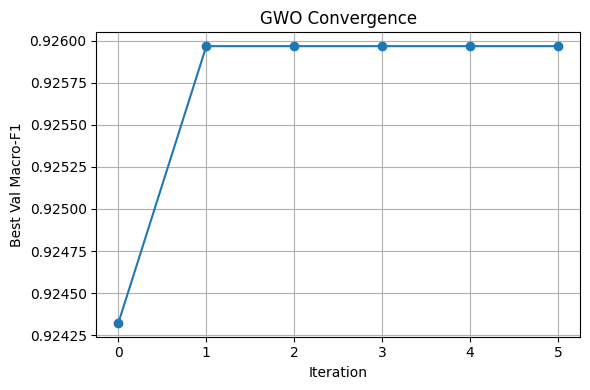

Saved convergence plot to: /kaggle/working/abtm_gwo/convergence.png

[GWO] BEST: {'val_macro_f1': 0.9259677529335022, 'lr': 0.0007570403814315796, 'dropout': 0.1179435133934021, 'dense_units': 64, 'seed': 42, 'pop': 8, 'iters': 5} (~60.0 min)
Saved: /kaggle/working/abtm_gwo/gwo_best.json


In [13]:
# ============================================================
# Cell — GWO Hyperparam Search (lr, dropout, dense_units) — FAST & ROBUST
# Objective: maximize validation Macro-F1 using a fast PyTorch proxy model.
# Inputs required (already prepared by your earlier cells):
#   Xtr_ids, Xtr_mask, y_tr, Xtr_tfidf, Xtr_bow
#   Xva_ids, Xva_mask, y_va, Xva_tfidf, Xva_bow
#   Config (with MAX_LENGTH, OUTPUT_DIR) and/or CONFIG for MAX_LEN
# Outputs (saved under Config.OUTPUT_DIR, e.g. /kaggle/working/abtm_gwo):
#   - trials.csv        (all evaluations)
#   - best.json         (best hyperparams)
#   - convergence.png   (best Macro-F1 over iterations)
#   - gwo_best.json     (same as best.json for convenience)
# ============================================================

import warnings

# Hide only FutureWarning messages
warnings.filterwarnings("ignore", category=FutureWarning)

# Or hide all warnings (not recommended, چون ممکنه ارور مهم هم قایم بشه)
# warnings.filterwarnings("ignore")


import os, json, time, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score, accuracy_score
from scipy import sparse

# ----------------------------
# 0) Device & Reproducibility
# ----------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

SEED = 42
set_seed(SEED)

device = torch.device(getattr(Config, "DEVICE", "cuda") if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type != "cuda":
    print("CUDA not detected – this will be slow on CPU.")

torch.backends.cudnn.benchmark = True

# ------------------------------------------
# 1) Lightweight ABTMDeep proxy (if missing)
#    Produces a 256-dim deep vector from ids/mask.
# ------------------------------------------
if 'ABTMDeep' not in globals():
    class ABTMDeep(nn.Module):
        """
        Fast proxy: token embedding (256) + positional embedding + 1 TransformerEncoder
        + masked mean pooling → (B, 256). This is only for hyperparam search.
        """
        def __init__(self, vocab_size, max_len, dropout=0.1, d_model=256, nhead=2, ff=256):
            super().__init__()
            self.tok = nn.Embedding(vocab_size, d_model)
            self.pos = nn.Embedding(max_len, d_model)
            enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                             dim_feedforward=ff, dropout=dropout,
                                             batch_first=True)
            self.enc = nn.TransformerEncoder(enc, num_layers=1)
            self.dropout = nn.Dropout(dropout)

        def forward(self, ids, mask):
            B, L = ids.size()
            pos = torch.arange(L, device=ids.device).unsqueeze(0).expand(B, L)
            x = self.tok(ids) + self.pos(pos)
            x = self.enc(x, src_key_padding_mask=(mask == 0))  # True on pads
            x = self.dropout(x)
            m = (mask > 0).float().unsqueeze(-1)               # (B, L, 1)
            return (x * m).sum(1) / m.sum(1).clamp(min=1.0)    # (B, 256)

# ------------------------------------------
# 2) Parametric Fusion Head for ABTM (Torch)
# ------------------------------------------
class ABTMFusionModelGWO(nn.Module):
    """
    Deep branch: ABTMDeep(...)-> (B, 256)
    Fusion: concat([deep, tfidf(1000), bow(1000)]) -> Dense(dense_units) -> Dropout -> num_classes
    """
    def __init__(self, vocab_size, max_len, tfidf_dim, bow_dim, num_classes,
                 dropout=0.1, dense_units=64):
        super().__init__()
        self.deep = ABTMDeep(vocab_size=vocab_size, max_len=max_len, dropout=dropout)  # → (B, 256)
        fused_in = 256 + tfidf_dim + bow_dim
        self.classifier = nn.Sequential(
            nn.Linear(fused_in, dense_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_units, num_classes)
        )
    def forward(self, ids, mask, tfidf, bow):
        deep_vec = self.deep(ids, mask)             # (B, 256)
        fused = torch.cat([deep_vec, tfidf, bow], dim=-1)
        return self.classifier(fused)

# ------------------------------------------------
# 3) Build fast subset loaders (dense precompute)
# ------------------------------------------------
SUBSET_FRAC = 0.20   # 20% of train for proxy search (coarse stage)
EVAL_EPOCHS = 2      # quick eval (2 epochs per candidate)
BS           = 16
PIN_MEMORY   = (device.type == "cuda")
NUM_WORKERS  = 2

def _to_dense_f32(x):
    """Convert np/scipy array to dense float32 2D array."""
    if sparse.issparse(x):
        return x.toarray().astype(np.float32, copy=False)
    x = np.asarray(x)
    if x.dtype != np.float32:
        x = x.astype(np.float32, copy=False)
    return x

# Required arrays must exist from your alias cell
assert all(k in globals() for k in ["Xtr_ids","Xtr_mask","y_tr","Xtr_tfidf","Xtr_bow"]), "Training arrays missing."
assert all(k in globals() for k in ["Xva_ids","Xva_mask","y_va","Xva_tfidf","Xva_bow"]), "Validation arrays missing."

# Stratified-ish random subset (simple proportional sampling)
rng = np.random.RandomState(SEED)
n_train = len(y_tr)
subset_n = max(512, int(n_train * SUBSET_FRAC))
subset_idx = rng.choice(n_train, size=subset_n, replace=False)

sub_ids   = Xtr_ids[subset_idx]
sub_mask  = Xtr_mask[subset_idx]
sub_y     = y_tr[subset_idx]
sub_tfidf = _to_dense_f32(Xtr_tfidf[subset_idx])
sub_bow   = _to_dense_f32(Xtr_bow[subset_idx])

# Validation (full) in dense float32
val_ids   = Xva_ids
val_mask  = Xva_mask
val_y     = y_va
val_tfidf = _to_dense_f32(Xva_tfidf)
val_bow   = _to_dense_f32(Xva_bow)

class FusionDataset(Dataset):
    def __init__(self, ids, mask, y, X_tfidf_dense, X_bow_dense):
        self.ids   = ids
        self.mask  = mask
        self.y     = np.asarray(y, dtype=np.int64)
        self.tfidf = X_tfidf_dense
        self.bow   = X_bow_dense
        assert self.tfidf.ndim == 2 and self.bow.ndim == 2
        assert len(self.y) == len(self.ids) == len(self.mask) == len(self.tfidf) == len(self.bow)
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return (
            torch.tensor(self.ids[i],   dtype=torch.long),
            torch.tensor(self.mask[i],  dtype=torch.long),
            torch.tensor(self.tfidf[i], dtype=torch.float32),
            torch.tensor(self.bow[i],   dtype=torch.float32),
            torch.tensor(self.y[i],     dtype=torch.long),
        )

train_loader_gwo = DataLoader(
    FusionDataset(sub_ids, sub_mask, sub_y, sub_tfidf, sub_bow),
    batch_size=BS, shuffle=True, num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY, persistent_workers=(NUM_WORKERS > 0)
)
val_loader_gwo = DataLoader(
    FusionDataset(val_ids, val_mask, val_y, val_tfidf, val_bow),
    batch_size=BS, shuffle=False, num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY, persistent_workers=(NUM_WORKERS > 0)
)

# ---------------------------------------
# 4) Quick evaluation on subset (AMP + F1)
# ---------------------------------------
# Derive vocab size and max_len
vocab_guess = int(Xtr_ids.max()) + 1
vocab_from_tok = int(getattr(globals().get("tokenizer", None), "vocab_size", 0) or 0)
vocab_size = max(vocab_guess, (vocab_from_tok + 1) if vocab_from_tok > 0 else 0, 32000)  # safe floor at 32k
max_len = int(getattr(Config, "MAX_LENGTH", Xtr_ids.shape[1]))

num_classes = int(len(np.unique(y_tr)))
tfidf_dim   = sub_tfidf.shape[1]
bow_dim     = sub_bow.shape[1]
use_amp     = (device.type == "cuda")

def quick_eval(lr, dropout, dense_units):
    """
    Train the Fusion model quickly on the training subset, evaluate on full validation.
    Returns: (val_macro_f1, val_accuracy)
    """
    torch.cuda.empty_cache()
    model_tmp = ABTMFusionModelGWO(
        vocab_size=vocab_size, max_len=max_len,
        tfidf_dim=tfidf_dim, bow_dim=bow_dim, num_classes=num_classes,
        dropout=dropout, dense_units=dense_units
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.NAdam(model_tmp.parameters(), lr=lr)
    scaler    = torch.cuda.amp.GradScaler(enabled=use_amp)

    def run_epoch(loader, train=True):
        model_tmp.train(train)
        y_true, y_pred = [], []
        total_loss, n = 0.0, 0

        for ids, msk, tfidf_b, bow_b, y in loader:
            ids  = ids.to(device, non_blocking=True)
            msk  = msk.to(device, non_blocking=True)
            tfidf_b = tfidf_b.to(device, non_blocking=True)
            bow_b   = bow_b.to(device, non_blocking=True)
            y    = y.to(device, non_blocking=True)

            with torch.set_grad_enabled(train):
                with torch.cuda.amp.autocast(enabled=use_amp):
                    logits = model_tmp(ids, msk, tfidf_b, bow_b)
                    loss   = criterion(logits, y)

                if train:
                    optimizer.zero_grad(set_to_none=True)
                    scaler.scale(loss).backward()
                    torch.nn.utils.clip_grad_norm_(model_tmp.parameters(), 1.0)
                    scaler.step(optimizer)
                    scaler.update()

            bs = y.size(0)
            total_loss += loss.item() * bs
            n += bs
            y_pred.extend(logits.argmax(1).detach().cpu().numpy().tolist())
            y_true.extend(y.detach().cpu().numpy().tolist())

        avg_loss = total_loss / max(n, 1)
        acc = accuracy_score(y_true, y_pred)
        f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
        return avg_loss, acc, f1m

    best_va_f1 = -1.0
    va_acc_last = 0.0
    for _ in range(EVAL_EPOCHS):
        _ = run_epoch(train_loader_gwo, train=True)
        _, va_acc, va_f1 = run_epoch(val_loader_gwo,   train=False)
        va_acc_last = va_acc
        best_va_f1 = max(best_va_f1, va_f1)

    return best_va_f1, va_acc_last

# ----------------------------------------------
# 5) Map wolf vector x∈[0,1]^3 → (lr, dropout, units)
# ----------------------------------------------
UNITS_CHOICES = [32, 48, 64, 96, 128]
def decode(x):
    x = np.clip(np.array(x, dtype=np.float32), 0.0, 1.0)
    lr = 5e-4 + x[0] * (2e-3 - 5e-4)    # [5e-4, 2e-3]
    dr = 0.05 + x[1] * (0.30 - 0.05)    # [0.05, 0.30]
    idx = min(int(x[2] * len(UNITS_CHOICES)), len(UNITS_CHOICES) - 1)
    units = UNITS_CHOICES[idx]
    return float(lr), float(dr), int(units)

# ------------------------------------------
# 6) Grey Wolf Optimizer (with full logging)
# ------------------------------------------
def gwo_optimize(pop=8, iters=5, seed=2024, out_dir="./gwo_out"):
    rng = np.random.RandomState(seed)
    os.makedirs(out_dir, exist_ok=True)

    wolves  = rng.rand(pop, 3).astype(np.float32)
    fitness = np.zeros(pop, dtype=np.float32)
    accs    = np.zeros(pop, dtype=np.float32)

    trials_csv = os.path.join(out_dir, "trials.csv")
    with open(trials_csv, "w") as f:
        f.write("iter,wolf,lr,dropout,dense_units,val_macro_f1,val_acc\n")

    # Initial evaluation
    for i in range(pop):
        lr, dr, un = decode(wolves[i])
        f1m, acc = quick_eval(lr, dr, un)
        fitness[i] = f1m
        accs[i]    = acc
        with open(trials_csv, "a") as f:
            f.write(f"0,{i},{lr:.6f},{dr:.4f},{un},{f1m:.6f},{acc:.6f}\n")

    order = np.argsort(-fitness)
    alpha, beta, delta = wolves[order[0]].copy(), wolves[order[1]].copy(), wolves[order[2]].copy()
    f_alpha, f_beta, f_delta = fitness[order[0]], fitness[order[1]], fitness[order[2]]

    print(f"[GWO] init best val_macroF1={f_alpha:.4f}  (lr,dropout,units)={decode(alpha)}")
    best_hist = [float(f_alpha)]

    for t in range(1, iters + 1):
        a = 2 - 2 * (t / iters)
        for i in range(pop):
            X = wolves[i]
            Xm = np.zeros_like(X)
            for leader in [alpha, beta, delta]:
                A = 2 * a * rng.rand(3) - a
                C = 2 * rng.rand(3)
                D = np.abs(C * leader - X)
                Xm += (leader - A * D)
            wolves[i] = np.clip(Xm / 3.0, 0.0, 1.0)

        # Evaluate population
        for i in range(pop):
            lr, dr, un = decode(wolves[i])
            f1m, acc = quick_eval(lr, dr, un)
            fitness[i] = f1m
            accs[i]    = acc
            with open(trials_csv, "a") as f:
                f.write(f"{t},{i},{lr:.6f},{dr:.4f},{un},{f1m:.6f},{acc:.6f}\n")

        order = np.argsort(-fitness)
        if fitness[order[0]] > f_alpha:
            alpha, f_alpha = wolves[order[0]].copy(), fitness[order[0]]
        if fitness[order[1]] > f_beta:
            beta,  f_beta  = wolves[order[1]].copy(), fitness[order[1]]
        if fitness[order[2]] > f_delta:
            delta, f_delta = wolves[order[2]].copy(), fitness[order[2]]

        best_hist.append(float(f_alpha))
        print(f"[GWO] iter {t:02d}/{iters}  best val_macroF1={f_alpha:.4f}  params={decode(alpha)}")

    # Save best + convergence plot
    best_lr, best_dr, best_units = decode(alpha)
    best_json = {
        "val_macro_f1": float(f_alpha),
        "lr": best_lr, "dropout": best_dr, "dense_units": int(best_units),
        "seed": int(seed), "pop": int(pop), "iters": int(iters)
    }
    with open(os.path.join(out_dir, "best.json"), "w") as f:
        json.dump(best_json, f, indent=2)

    plt.figure(figsize=(6, 4))
    plt.plot(best_hist, marker="o")
    plt.xlabel("Iteration"); plt.ylabel("Best Val Macro-F1"); plt.title("GWO Convergence")
    plt.grid(True); plt.tight_layout()
    conv_path = os.path.join(out_dir, "convergence.png")
    plt.savefig(conv_path, dpi=150); plt.show()
    print("Saved convergence plot to:", conv_path)

    return best_json, best_hist

# --------------------
# 7) Run the optimizer
# --------------------
OUT_DIR = getattr(Config, "OUTPUT_DIR", "/kaggle/working/abtm_gwo")
os.makedirs(OUT_DIR, exist_ok=True)

start = time.time()
best, hist = gwo_optimize(pop=8, iters=5, seed=SEED, out_dir=OUT_DIR)
dur_min = (time.time() - start) / 60.0

print("\n[GWO] BEST:", best, f"(~{dur_min:.1f} min)")
with open(f"{OUT_DIR}/gwo_best.json", "w") as f:
    json.dump(best, f, indent=2)
print("Saved:", f"{OUT_DIR}/gwo_best.json")


## Apply GWO HPs → Rebuild, Train, Evaluate, Save

In [14]:
# # =========================================================
# # Cell — Apply GWO HPs → Rebuild, Train, Evaluate, Save
# # =========================================================
# import os, json, numpy as np, matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras import layers, Model, optimizers, losses, backend as K
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import to_categorical
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

# # ---------- 1) Load best hyperparams from GWO ----------
# best_path = "/kaggle/working/abtm_gwo/gwo_best.json"
# if not os.path.exists(best_path):
#     alt = "/kaggle/working/abtm_gwo/best.json"
#     if os.path.exists(alt): best_path = alt
# with open(best_path) as f:
#     BEST_HP = json.load(f)

# CONFIG["LR"]          = float(BEST_HP["lr"])
# CONFIG["DROPOUT"]     = float(BEST_HP["dropout"])
# CONFIG["DENSE_UNITS"] = int(BEST_HP["dense_units"])
# print("Using GWO HPs:", {k: CONFIG[k] for k in ["LR","DROPOUT","DENSE_UNITS"]})

# # ---------- 2) Rebuild ABTM with new HPs ----------
# K.clear_session()

# MAX_LEN     = CONFIG["MAX_LEN"]
# EMBED_DIM   = CONFIG["EMBED_DIM"]
# NUM_HEADS   = CONFIG["NUM_HEADS"]
# FF_DIM      = CONFIG["FF_DIM"]
# GRU_UNITS   = CONFIG["GRU_UNITS"]
# LSTM_UNITS  = CONFIG["LSTM_UNITS"]
# DENSE_UNITS = CONFIG["DENSE_UNITS"]      # <- from GWO
# DROPOUT     = CONFIG["DROPOUT"]          # <- from GWO
# NUM_CLASSES = CONFIG["NUM_CLASSES"]
# TF_DIM      = CONFIG["TFIDF_MAX_FEATURES"]
# BOW_DIM     = CONFIG["BOW_MAX_FEATURES"]

# # Inputs (same names as before)
# X_in = layers.Input(shape=(MAX_LEN,), dtype="int32",   name="X")
# M_in = layers.Input(shape=(MAX_LEN,), dtype="int32",   name="M")
# T_in = layers.Input(shape=(TF_DIM,),  dtype="float32", name="T")
# B_in = layers.Input(shape=(BOW_DIM,), dtype="float32", name="B")

# # CustomAttentionEmbedder & TransformerBlock must be defined in Cell 8 (you already ran it)
# vocab_plus = tokenizer.vocab_size + 1
# E = CustomAttentionEmbedder(
#         vocab_size=vocab_plus,
#         embedding_dim=EMBED_DIM,
#         max_length=MAX_LEN,
#         num_heads=NUM_HEADS,
#         name="CustomAttentionEmbedder"
#     )(X_in)

# H = layers.Bidirectional(layers.GRU(GRU_UNITS, return_sequences=True),
#                          merge_mode="concat", name="BiGRU")(E)
# H = layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=True),
#                          merge_mode="concat", name="BiLSTM")(H)

# T_out = TransformerBlock(d_model=EMBED_DIM, num_heads=NUM_HEADS, ff_dim=FF_DIM,
#                          name="TransformerBlock")(H, mask=M_in)

# P = layers.GlobalAveragePooling1D(name="GlobalAveragePooling1D")(T_out)
# C = layers.Concatenate(name="ConcatenateFeatures")([P, T_in, B_in])

# Z = layers.Dense(DENSE_UNITS, activation="relu", name="Dense_GWO")(C)  # <- units from GWO
# Z = layers.Dropout(DROPOUT, name="Dropout_GWO")(Z)                      # <- dropout from GWO
# Y_out = layers.Dense(NUM_CLASSES, activation="softmax", name="Softmax")(Z)

# model_gwo = Model(inputs=[X_in, M_in, T_in, B_in], outputs=Y_out, name="ABTM_GWO")

# opt = optimizers.Nadam(learning_rate=CONFIG["LR"])  # <- LR from GWO
# model_gwo.compile(optimizer=opt,
#                   loss=losses.CategoricalCrossentropy(),
#                   metrics=["accuracy"])
# model_gwo.summary()

# # ---------- 3) Train on full TRAIN (augmented) ----------
# y_train_oh = to_categorical(y_train, num_classes=NUM_CLASSES)
# y_val_oh   = to_categorical(y_val,   num_classes=NUM_CLASSES)
# y_test_oh  = to_categorical(y_test,  num_classes=NUM_CLASSES)

# es = EarlyStopping(monitor="val_accuracy",
#                    patience=CONFIG["EARLY_STOPPING_PATIENCE"],
#                    restore_best_weights=True)

# history_gwo = model_gwo.fit(
#     x={"X": train_input_ids, "M": train_attn, "T": X_train_tfidf, "B": X_train_bow},
#     y=y_train_oh,
#     validation_data=(
#         {"X": val_input_ids, "M": val_attn, "T": X_val_tfidf, "B": X_val_bow},
#         y_val_oh
#     ),
#     epochs=CONFIG["EPOCHS"],
#     batch_size=CONFIG["BATCH_SIZE"],
#     callbacks=[es],
#     verbose=1
# )

# # ---------- 4) Evaluate (VAL / TEST) ----------
# val_loss, val_acc   = model_gwo.evaluate({"X": val_input_ids, "M": val_attn, "T": X_val_tfidf, "B": X_val_bow}, y_val_oh,  verbose=0)
# test_loss, test_acc = model_gwo.evaluate({"X": test_input_ids,"M": test_attn,"T": X_test_tfidf,"B": X_test_bow}, y_test_oh, verbose=0)

# # Macro metrics on TEST
# probs = model_gwo.predict({"X": test_input_ids,"M": test_attn,"T": X_test_tfidf,"B": X_test_bow}, verbose=0)
# y_pred = probs.argmax(axis=1)
# test_acc_m = accuracy_score(y_test, y_pred)
# prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)

# print(f"\n[GWO] VAL  acc: {val_acc:.4f}")
# print(f"[GWO] TEST acc: {test_acc:.4f}")
# print(f"[GWO] TEST Macro — P: {prec_m:.4f} | R: {rec_m:.4f} | F1: {f1_m:.4f}")

# # ---------- 5) Save artifacts & quick ablation vs baseline (if available) ----------
# out_dir = "/kaggle/working/abtm_light_gwo"
# os.makedirs(out_dir, exist_ok=True)
# model_gwo.save(f"{out_dir}/abtm_gwo_model.keras")

# # training curves (PNG)
# hist = history_gwo.history
# plt.figure(figsize=(7,4)); plt.plot(hist["accuracy"], label="train_acc"); plt.plot(hist["val_accuracy"], label="val_acc")
# plt.title("Accuracy (GWO)"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(); plt.tight_layout()
# plt.savefig(f"{out_dir}/acc_gwo.png", dpi=150); plt.close()

# plt.figure(figsize=(7,4)); plt.plot(hist["loss"], label="train_loss"); plt.plot(hist["val_loss"], label="val_loss")
# plt.title("Loss (GWO)"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout()
# plt.savefig(f"{out_dir}/loss_gwo.png", dpi=150); plt.close()

# # store summary
# summary = {"val_acc": float(val_acc), "test_acc": float(test_acc),
#            "macro_precision": float(prec_m), "macro_recall": float(rec_m), "macro_f1": float(f1_m),
#            "lr": CONFIG["LR"], "dropout": CONFIG["DROPOUT"], "dense_units": DENSE_UNITS}
# with open(f"{out_dir}/summary_gwo.json","w") as f: json.dump(summary, f, indent=2)

# # optional: ablation vs baseline model (if baseline exists)
# abl_path = f"{out_dir}/ablation.csv"
# rows = []
# if 'model' in globals():
#     # baseline probs/preds
#     base_probs = model.predict({"X": test_input_ids,"M": test_attn,"T": X_test_tfidf,"B": X_test_bow}, verbose=0)
#     base_pred  = base_probs.argmax(axis=1)
#     base_acc   = accuracy_score(y_test, base_pred)
#     base_f1    = f1_score(y_test, base_pred, average="macro", zero_division=0)
#     rows.append(["Baseline", float(base_acc), float(base_f1)])
# rows.append(["GWO", float(test_acc_m), float(f1_m)])

# import csv
# with open(abl_path, "w", newline="") as f:
#     w = csv.writer(f); w.writerow(["model","test_acc","test_macro_f1"]); w.writerows(rows)

# print(f"\nSaved: {out_dir}/abtm_gwo_model.keras")
# print(f"Saved: {out_dir}/summary_gwo.json")
# print(f"Saved: {out_dir}/acc_gwo.png, {out_dir}/loss_gwo.png")
# print(f"Saved: {abl_path}")


In [15]:
# =========================================================
# Cell — Apply GWO HPs → Build, Train, Evaluate, Save (robust)
# =========================================================
import os, json, time, inspect, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
import pandas as pd

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# -------- Sanity checks: these must be defined by earlier cells --------
req = [
    'tokenizer','CONFIG',
    'train_input_ids','train_attn','val_input_ids','val_attn','test_input_ids','test_attn',
    'X_train_tfidf','X_train_bow','X_val_tfidf','X_val_bow','X_test_tfidf','X_test_bow',
    'y_train','y_val','y_test',
    'CustomAttentionEmbedder','TransformerBlock'
]
missing = [v for v in req if v not in globals()]
assert not missing, f"Missing required variables: {missing}"

# -------- Locate GWO best hyperparameters (several common locations) --------
candidates = [
    os.path.join(CONFIG.get("OUTPUT_DIR", "/kaggle/working/abtm_light_gwo"), "gwo_best.json"),
    os.path.join(CONFIG.get("OUTPUT_DIR", "/kaggle/working/abtm_light_gwo"), "best.json"),
    "/kaggle/working/abtm_gwo/gwo_best.json",
    "/kaggle/working/abtm_gwo/best.json",
    "/kaggle/working/abtm_light_gwo/gwo_best.json",
    "/kaggle/working/abtm_light_gwo/best.json",
]
best_path = next((p for p in candidates if os.path.exists(p)), None)
assert best_path, f"No GWO results found at any of: {candidates}"
BEST = json.load(open(best_path, "r"))

# Extract HPs with safe defaults
LR          = float(BEST.get("lr", 8e-4))
DROPOUT     = float(BEST.get("dropout", 0.10))
DENSE_UNITS = int(BEST.get("dense_units", CONFIG.get("DENSE_UNITS", 64)))
BATCH       = int(BEST.get("batch_size", CONFIG.get("BATCH_SIZE", 16)))

print("Using GWO HPs:", {"LR": LR, "DROPOUT": DROPOUT, "DENSE_UNITS": DENSE_UNITS, "BATCH": BATCH})

# -------- Build ABTM (paper-faithful) with compatibility shims --------
def build_abtm_model(lr, dropout, dense_units):
    """
    Builds the ABTM model robustly to signature differences in CustomAttentionEmbedder/TransformerBlock.
    It tries 'embedding_dim' first (your error), then falls back to 'd_model'. It also tries passing mask.
    """
    # Read config
    MAX_LEN     = CONFIG["MAX_LEN"]
    EMBED_DIM   = CONFIG["EMBED_DIM"]
    NUM_HEADS   = CONFIG["NUM_HEADS"]
    FF_DIM      = CONFIG["FF_DIM"]
    GRU_UNITS   = CONFIG["GRU_UNITS"]
    LSTM_UNITS  = CONFIG["LSTM_UNITS"]
    NUM_CLASSES = CONFIG["NUM_CLASSES"]
    TF_DIM      = CONFIG["TFIDF_MAX_FEATURES"]
    BOW_DIM     = CONFIG["BOW_MAX_FEATURES"]

    # Clear previous graph
    K.clear_session()

    # Inputs
    X_in = layers.Input(shape=(MAX_LEN,), dtype="int32",   name="X")  # token ids
    M_in = layers.Input(shape=(MAX_LEN,), dtype="int32",   name="M")  # attention mask
    T_in = layers.Input(shape=(TF_DIM,),  dtype="float32", name="T")  # TF-IDF
    B_in = layers.Input(shape=(BOW_DIM,), dtype="float32", name="B")  # BoW

    vocab_plus = int(getattr(tokenizer, "vocab_size", 0)) + 1

    # ---- CustomAttentionEmbedder: robust init (embedding_dim vs d_model) ----
    emb_sig = inspect.signature(CustomAttentionEmbedder.__init__)
    emb_params = emb_sig.parameters
    emb_kwargs = {"vocab_size": vocab_plus}

    if "name" in emb_params:       emb_kwargs["name"] = "CustomAttentionEmbedder"
    if "max_length" in emb_params: emb_kwargs["max_length"] = MAX_LEN

    # ← key fix: prefer 'embedding_dim' if available, else 'd_model'
    if "embedding_dim" in emb_params:
        emb_kwargs["embedding_dim"] = EMBED_DIM
    elif "d_model" in emb_params:
        emb_kwargs["d_model"] = EMBED_DIM
    else:
        # Last-resort: still pass as 'embedding_dim'
        emb_kwargs["embedding_dim"] = EMBED_DIM

    if "num_heads" in emb_params: emb_kwargs["num_heads"] = NUM_HEADS
    if "dropout" in emb_params:   emb_kwargs["dropout"]   = dropout
    if "pad_id" in emb_params:    emb_kwargs["pad_id"]    = 0

    embedder = CustomAttentionEmbedder(**emb_kwargs)

    # Call embedder: try (x, mask) → ([x,mask]) → (x)
    try:
        E = embedder(X_in, M_in)
    except TypeError:
        try:
            E = embedder([X_in, M_in])
        except TypeError:
            E = embedder(X_in)

    # Sequence blocks: BiGRU → BiLSTM
    H = layers.Bidirectional(layers.GRU(GRU_UNITS, return_sequences=True),
                             merge_mode="concat", name="BiGRU")(E)
    H = layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=True),
                             merge_mode="concat", name="BiLSTM")(H)

    # ---- TransformerBlock: robust construction & call ----
    tr_sig = inspect.signature(TransformerBlock.__init__)
    tr_params = tr_sig.parameters

    if {"d_model","num_heads","ff_dim"}.issubset(tr_params.keys()):
        try:
            TR = TransformerBlock(d_model=EMBED_DIM, num_heads=NUM_HEADS, ff_dim=FF_DIM, name="TransformerBlock")
        except TypeError:
            TR = TransformerBlock(d_model=EMBED_DIM, num_heads=NUM_HEADS, ff_dim=FF_DIM)
    else:
        try:
            TR = TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM, name="TransformerBlock")
        except TypeError:
            TR = TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM)

    # call with mask if possible
    try:
        T_out = TR(H, mask=M_in)
    except TypeError:
        try:
            T_out = TR([H, M_in])
        except TypeError:
            T_out = TR(H)

    # Pool → concat classical features
    P = layers.GlobalAveragePooling1D(name="GlobalAveragePooling1D")(T_out)
    C = layers.Concatenate(name="ConcatenateFeatures")([P, T_in, B_in])

    # Dense → Dropout → Softmax (units/dropout from GWO)
    Z = layers.Dense(dense_units, activation="relu", name="Dense_GWO")(C)
    Z = layers.Dropout(dropout, name="Dropout_GWO")(Z)
    Y = layers.Dense(NUM_CLASSES, activation="softmax", name="Softmax")(Z)

    model = Model(inputs=[X_in, M_in, T_in, B_in], outputs=Y, name="ABTM_GWO")
    model.compile(optimizer=optimizers.Nadam(learning_rate=lr),
                  loss=losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])
    return model

# -------- Train --------
model_gwo = build_abtm_model(LR, DROPOUT, DENSE_UNITS)
model_gwo.summary()

NUM_CLASSES = CONFIG["NUM_CLASSES"]
y_train_oh = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_oh   = to_categorical(y_val,   num_classes=NUM_CLASSES)
y_test_oh  = to_categorical(y_test,  num_classes=NUM_CLASSES)

es = EarlyStopping(monitor="val_accuracy",
                   patience=CONFIG.get("EARLY_STOPPING_PATIENCE", 3),
                   restore_best_weights=True)

t0 = time.time()
history_gwo = model_gwo.fit(
    x={"X": train_input_ids, "M": train_attn, "T": X_train_tfidf, "B": X_train_bow},
    y=y_train_oh,
    validation_data=(
        {"X": val_input_ids, "M": val_attn, "T": X_val_tfidf, "B": X_val_bow},
        y_val_oh
    ),
    epochs=CONFIG.get("EPOCHS", 10),
    batch_size=BATCH,
    callbacks=[es],
    verbose=1
)
train_time_sec = time.time() - t0

# -------- Evaluate (VAL/TEST) --------
val_loss, val_acc   = model_gwo.evaluate(
    {"X": val_input_ids, "M": val_attn, "T": X_val_tfidf, "B": X_val_bow},
    y_val_oh, verbose=0
)
probs = model_gwo.predict({"X": test_input_ids, "M": test_attn, "T": X_test_tfidf, "B": X_test_bow}, verbose=0)
y_pred = probs.argmax(axis=1)

test_acc = accuracy_score(y_test, y_pred)
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)
f1_w = f1_score(y_test, y_pred, average="weighted", zero_division=0)

print(f"\n[GWO] VAL  acc: {val_acc:.4f}")
print(f"[GWO] TEST acc: {test_acc:.4f}")
print(f"[GWO] TEST Macro — P: {prec_m:.4f} | R: {rec_m:.4f} | F1: {f1_m:.4f}")
print(f"[GWO] TEST Weighted-F1: {f1_w:.4f}")
print("\nPer-class (TEST):\n", classification_report(y_test, y_pred, digits=4))

# -------- Save artifacts --------
out_dir = CONFIG.get("OUTPUT_DIR", "/kaggle/working/abtm_light_gwo")
os.makedirs(out_dir, exist_ok=True)

# Model
model_gwo.save(os.path.join(out_dir, "abtm_gwo_model.keras"))

# Training curves
hist = history_gwo.history
plt.figure(figsize=(7,4))
plt.plot(hist.get("accuracy", []), label="train_acc")
plt.plot(hist.get("val_accuracy", []), label="val_acc")
plt.title("Accuracy (GWO)"); plt.xlabel("epoch"); plt.ylabel("acc")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(out_dir, "acc_gwo.png"), dpi=150); plt.close()

plt.figure(figsize=(7,4))
plt.plot(hist.get("loss", []), label="train_loss")
plt.plot(hist.get("val_loss", []), label="val_loss")
plt.title("Loss (GWO)"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(out_dir, "loss_gwo.png"), dpi=150); plt.close()

# Summary JSON/CSV
summary = {
    "val_acc": float(val_acc),
    "test_acc": float(test_acc),
    "macro_precision": float(prec_m),
    "macro_recall": float(rec_m),
    "macro_f1": float(f1_m),
    "weighted_f1": float(f1_w),
    "lr": float(LR),
    "dropout": float(DROPOUT),
    "dense_units": int(DENSE_UNITS),
    "batch_size": int(BATCH),
    "train_time_sec": float(train_time_sec),
}
with open(os.path.join(out_dir, "summary_gwo.json"), "w") as f:
    json.dump(summary, f, indent=2)

pd.DataFrame([summary]).to_csv(os.path.join(out_dir, "summary_gwo.csv"), index=False)

# Per-class CSV
labels_sorted = sorted(np.unique(y_test))
prec_c, rec_c, f1_c, sup_c = precision_recall_fscore_support(
    y_test, y_pred, labels=labels_sorted, average=None, zero_division=0
)
per_class = pd.DataFrame({
    "label":     labels_sorted,
    "precision": np.round(prec_c, 4),
    "recall":    np.round(rec_c, 4),
    "f1":        np.round(f1_c, 4),
    "support":   sup_c.astype(int),
})
per_class.to_csv(os.path.join(out_dir, "per_class_gwo.csv"), index=False)

print(f"\nSaved to: {out_dir}")
print(" - abtm_gwo_model.keras")
print(" - summary_gwo.json / summary_gwo.csv")
print(" - acc_gwo.png / loss_gwo.png")
print(" - per_class_gwo.csv")


Using GWO HPs: {'LR': 0.0007570403814315796, 'DROPOUT': 0.1179435133934021, 'DENSE_UNITS': 64, 'BATCH': 16}


I0000 00:00:1759752632.354273      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13580 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759752632.355192      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ABTM_GWO"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X (InputLayer)      │ (None, 512)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M (InputLayer)      │ (None, 512)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_attention_e… │ (None, 512, 256)  │  8,586,496 │ X[0][0], M[0][0]  │
│ (CustomAttentionEm… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiGRU               │ (None, 512, 512)  │    789,504 │ custom_attention… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiLSTM              │ (None, 512, 256)  │    656,384 │ BiGRU[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TransformerBlock    │ (None, 512, 256)  │    395,776 │ BiLSTM[0][0],     │
│ (TransformerBlock)  │                   │            │ M[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalAveragePooli… │ (None, 256)       │          0 │ TransformerBlock… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T (InputLayer)      │ (None, 1000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ B (InputLayer)      │ (None, 1000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ConcatenateFeatures │ (None, 2256)      │          0 │ GlobalAveragePoo… │
│ (Concatenate)       │                   │            │ T[0][0], B[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_GWO (Dense)   │ (None, 64)        │    144,448 │ ConcatenateFeatu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_GWO         │ (None, 64)        │          0 │ Dense_GWO[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Softmax (Dense)     │ (None, 5)         │        325 │ Dropout_GWO[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,572,933 (40.33 MB)

 Trainable params: 10,572,933 (40.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1759752655.738637     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


10879/10879 ━━━━━━━━━━━━━━━━━━━━ 1631s 148ms/step - accuracy: 0.9248 - loss: 0.2359 - val_accuracy: 0.9545 - val_loss: 0.1538
Epoch 2/10
10879/10879 ━━━━━━━━━━━━━━━━━━━━ 1610s 148ms/step - accuracy: 0.9675 - loss: 0.1033 - val_accuracy: 0.9488 - val_loss: 0.1852
Epoch 3/10
10879/10879 ━━━━━━━━━━━━━━━━━━━━ 1610s 148ms/step - accuracy: 0.9774 - loss: 0.0709 - val_accuracy: 0.9509 - val_loss: 0.2070
Epoch 4/10
10879/10879 ━━━━━━━━━━━━━━━━━━━━ 1610s 148ms/step - accuracy: 0.9836 - loss: 0.0505 - val_accuracy: 0.9477 - val_loss: 0.2398

[GWO] VAL  acc: 0.9545
[GWO] TEST acc: 0.9545
[GWO] TEST Macro — P: 0.9452 | R: 0.9410 | F1: 0.9429
[GWO] TEST Weighted-F1: 0.9543

Per-class (TEST):
               precision    recall  f1-score   support

           0     0.9667    0.9516    0.9591      2748
           1     0.9459    0.9770    0.9612      3346
           2     0.9242    0.8743    0.8986      2832
           3     0.9002    0.9072    0.9037      4096
           4     0.9889    0.9950    0.9

Saved: /kaggle/working/abtm_light_gwo/test_preds_gwo.csv


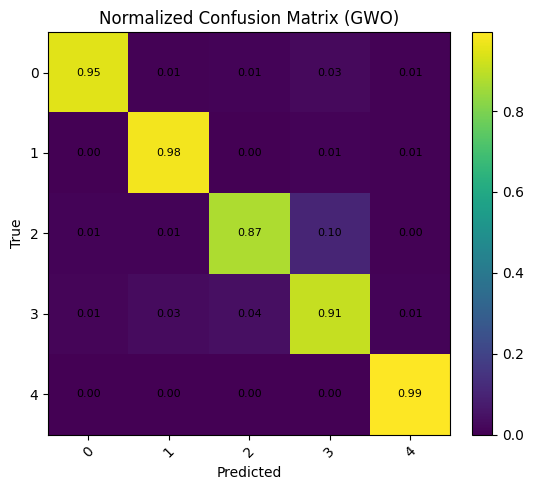

Saved: /kaggle/working/abtm_light_gwo/confusion_matrix_gwo.png


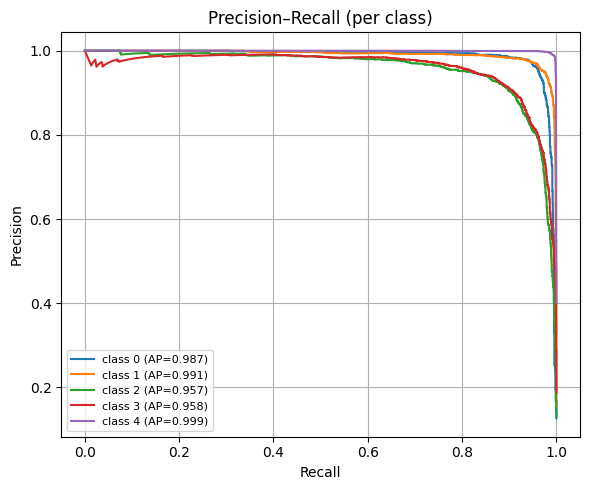

Saved: /kaggle/working/abtm_light_gwo/precision_recall_gwo.png


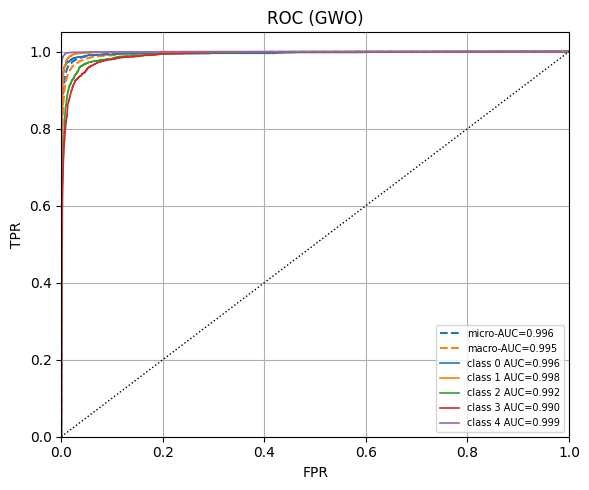

Saved: /kaggle/working/abtm_light_gwo/roc_gwo.png


In [16]:
# =========================
# Cell — GWO Evaluation Extras (TEST)
# Saves: test_preds_gwo.csv, confusion_matrix_gwo.png, precision_recall_gwo.png, roc_gwo.png
# =========================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, precision_recall_fscore_support,
    precision_recall_curve, average_precision_score,
    roc_curve, auc
)

out_dir = CONFIG.get("OUTPUT_DIR", "/kaggle/working/abtm_light_gwo")
os.makedirs(out_dir, exist_ok=True)

# 1) Predict & save preds
probs = model_gwo.predict(
    {"X": test_input_ids, "M": test_attn, "T": X_test_tfidf, "B": X_test_bow},
    verbose=0
)
y_pred = probs.argmax(axis=1)
pd.DataFrame({"y_true": y_test, "y_pred_gwo": y_pred}).to_csv(
    os.path.join(out_dir, "test_preds_gwo.csv"), index=False
)
print("Saved:", os.path.join(out_dir, "test_preds_gwo.csv"))

# 2) Confusion matrix (normalized)
labels = sorted(np.unique(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")

plt.figure(figsize=(6,5))
im = plt.imshow(cm, interpolation="nearest")
plt.title("Normalized Confusion Matrix (GWO)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted"); plt.ylabel("True")

# annotate
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f"{cm[i,j]:.2f}", ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "confusion_matrix_gwo.png"), dpi=150)
plt.show()
print("Saved:", os.path.join(out_dir, "confusion_matrix_gwo.png"))

# 3) Precision–Recall per class
num_classes = CONFIG["NUM_CLASSES"]
y_test_oh = np.eye(num_classes, dtype=np.float32)[np.asarray(y_test, dtype=int)]

plt.figure(figsize=(6,5))
aps = []
for c in range(num_classes):
    p, r, _ = precision_recall_curve(y_test_oh[:, c], probs[:, c])
    ap = average_precision_score(y_test_oh[:, c], probs[:, c])
    aps.append(ap)
    plt.plot(r, p, label=f"class {labels[c]} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (per class)")
plt.grid(True); plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "precision_recall_gwo.png"), dpi=150)
plt.show()
print("Saved:", os.path.join(out_dir, "precision_recall_gwo.png"))

# 4) ROC — micro & macro + per-class
from itertools import cycle
fpr, tpr, roc_auc = {}, {}, {}

for c in range(num_classes):
    fpr[c], tpr[c], _ = roc_curve(y_test_oh[:, c], probs[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])

# micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_oh.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro
all_fpr = np.unique(np.concatenate([fpr[c] for c in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for c in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr["micro"], tpr["micro"], linestyle="--", label=f"micro-AUC={roc_auc['micro']:.3f}")
plt.plot(all_fpr,     mean_tpr,     linestyle="--", label=f"macro-AUC={roc_auc['macro']:.3f}")

colors = cycle([f"C{i}" for i in range(10)])
for c, col in zip(range(num_classes), colors):
    plt.plot(fpr[c], tpr[c], color=col, lw=1.2, label=f"class {labels[c]} AUC={roc_auc[c]:.3f}")
plt.plot([0,1],[0,1], "k:", lw=1)
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (GWO)")
plt.grid(True); plt.legend(fontsize=7, loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "roc_gwo.png"), dpi=150)
plt.show()
print("Saved:", os.path.join(out_dir, "roc_gwo.png"))


In [17]:
# # ===============================================
# # Cell — FAST Bootstrap 95% CIs (vectorized)
# # Saves: gwo_bootstrap_ci.csv
# # ===============================================
# import os, numpy as np, pandas as pd
# from sklearn.metrics import accuracy_score, f1_score

# OUT = CONFIG.get("OUTPUT_DIR", "/kaggle/working/abtm_light_gwo")
# os.makedirs(OUT, exist_ok=True)

# pred_path = os.path.join(OUT, "test_preds_gwo.csv")

# # Load predictions (or create them from the trained model)
# if os.path.exists(pred_path):
#     df = pd.read_csv(pred_path)
#     y_true = df["y_true"].to_numpy()
#     # first column that starts with 'y_pred'
#     pred_col = [c for c in df.columns if c.startswith("y_pred")][0]
#     y_pred = df[pred_col].to_numpy()
# else:
#     probs  = model_gwo.predict({"X": test_input_ids, "M": test_attn,
#                                 "T": X_test_tfidf, "B": X_test_bow}, verbose=0)
#     y_pred = probs.argmax(1)
#     y_true = y_test
#     pd.DataFrame({"y_true": y_true, "y_pred_gwo": y_pred}).to_csv(pred_path, index=False)

# # Point estimates
# point_acc = accuracy_score(y_true, y_pred)
# point_f1m = f1_score(y_true, y_pred, average="macro",    zero_division=0)
# point_f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)

# # -------- Vectorized bootstrap --------
# B = 300  # می‌توانید 1000 هم بگذارید؛ 600 سریع و کافی است
# rng = np.random.default_rng(42)
# N  = y_true.shape[0]
# labels = np.unique(y_true)
# K = labels.size

# # Sample indices all at once: shape (B, N)
# idx = rng.integers(0, N, size=(B, N), dtype=np.int32)

# y_tb = y_true[idx]           # (B,N)
# y_pb = y_pred[idx]           # (B,N)

# # Accuracy (vectorized)
# acc_bs = (y_tb == y_pb).mean(axis=1)

# # Macro/Weighted-F1 via per-class TP/FP/FN (vectorized over B)
# eps = 1e-12
# tp = np.zeros((B, K), dtype=np.float64)
# fp = np.zeros((B, K), dtype=np.float64)
# fn = np.zeros((B, K), dtype=np.float64)
# support = np.zeros((B, K), dtype=np.float64)

# for j, c in enumerate(labels):
#     t = (y_tb == c)
#     p = (y_pb == c)
#     tp[:, j] = (t & p).sum(axis=1)
#     fp[:, j] = (~t & p).sum(axis=1)
#     fn[:, j] = (t & ~p).sum(axis=1)
#     support[:, j] = t.sum(axis=1)

# prec = tp / (tp + fp + eps)
# rec  = tp / (tp + fn + eps)
# f1_c = 2 * prec * rec / (prec + rec + eps)
# f1_c = np.nan_to_num(f1_c, nan=0.0)

# f1_macro_bs    = f1_c.mean(axis=1)
# f1_weighted_bs = (f1_c * support).sum(axis=1) / np.maximum(support.sum(axis=1), eps)

# # Compute 95% CIs
# def ci95(x):
#     lo, hi = np.percentile(x, [2.5, 97.5])
#     return float(lo), float(hi)

# rows = [
#     {"metric": "acc",         "point": point_acc, "ci_lo": ci95(acc_bs)[0],        "ci_hi": ci95(acc_bs)[1]},
#     {"metric": "f1_macro",    "point": point_f1m, "ci_lo": ci95(f1_macro_bs)[0],   "ci_hi": ci95(f1_macro_bs)[1]},
#     {"metric": "f1_weighted", "point": point_f1w, "ci_lo": ci95(f1_weighted_bs)[0],"ci_hi": ci95(f1_weighted_bs)[1]},
# ]
# out = pd.DataFrame(rows)
# out.to_csv(os.path.join(OUT, "gwo_bootstrap_ci.csv"), index=False)

# print(out)
# print("Saved:", os.path.join(OUT, "gwo_bootstrap_ci.csv"))


In [18]:
# ===============================================
# Cell — FAST Bootstrap 95% CIs (deterministic & safe)
# Saves:
#   - gwo_bootstrap_ci.csv        (point estimates + 95% CIs)
#   - gwo_bootstrap_meta.json     (run metadata: B, seed, determinism flag)
# Requirements:
#   - CONFIG["OUTPUT_DIR"] (optional; defaults applied)
#   - /.../test_preds_gwo.csv with columns: y_true, y_pred_gwo (or any y_pred*)
# Notes:
#   - Does NOT re-run the model. Reads saved predictions for reproducibility.
#   - Fully vectorized; stable results via fixed RNG seed.
# ===============================================
import os, json
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Optional: TensorFlow determinism (harmless if TF isn't loaded/available)
try:
    import tensorflow as tf
    try:
        tf.config.experimental.enable_op_determinism(True)
        _tf_deterministic = True
    except Exception:
        _tf_deterministic = False
except Exception:
    _tf_deterministic = False

# --------- Paths & IO helpers ---------
OUT = (CONFIG.get("OUTPUT_DIR") if isinstance(CONFIG, dict) and "OUTPUT_DIR" in CONFIG
       else "/kaggle/working/abtm_light_gwo")
os.makedirs(OUT, exist_ok=True)

pred_path = os.path.join(OUT, "test_preds_gwo.csv")

def _load_preds(path: str):
    """
    Load predictions CSV and return y_true, y_pred.
    Accepts any prediction column that starts with 'y_pred'.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"{path} not found. Create it once after test inference, e.g.:\n"
            "probs = model_gwo.predict({'X': test_input_ids, 'M': test_attn, 'T': X_test_tfidf, 'B': X_test_bow}, verbose=0)\n"
            "pd.DataFrame({'y_true': y_test, 'y_pred_gwo': probs.argmax(1)}).to_csv(path, index=False)"
        )
    df = pd.read_csv(path)
    assert "y_true" in df.columns, f"'y_true' column missing in: {path}"
    pred_cols = [c for c in df.columns if c.startswith("y_pred")]
    assert len(pred_cols) >= 1, f"No y_pred* column found in: {path}"
    y_true = df["y_true"].to_numpy()
    y_pred = df[pred_cols[0]].to_numpy()
    return y_true, y_pred

y_true, y_pred = _load_preds(pred_path)

# --------- Point estimates ---------
point_acc = accuracy_score(y_true, y_pred)
point_f1m = f1_score(y_true, y_pred, average="macro",    zero_division=0)
point_f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)

# --------- Vectorized bootstrap (reproducible) ---------
B = 300              # You can increase to 600/1000 for the paper's final table (slower).
SEED = 42            # Fixed seed for stable, repeatable CIs.
rng = np.random.default_rng(SEED)

y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)
N = y_true.shape[0]
labels = np.unique(y_true)
K = labels.size

# Sample indices in one shot: shape (B, N)
idx = rng.integers(0, N, size=(B, N), dtype=np.int32)
y_tb = y_true[idx]  # (B, N)
y_pb = y_pred[idx]  # (B, N)

# Accuracy (vectorized)
acc_bs = (y_tb == y_pb).mean(axis=1)

# Macro/Weighted-F1 via per-class TP/FP/FN (vectorized over B)
eps = 1e-12
tp = np.zeros((B, K), dtype=np.float64)
fp = np.zeros((B, K), dtype=np.float64)
fn = np.zeros((B, K), dtype=np.float64)
support = np.zeros((B, K), dtype=np.float64)

for j, c in enumerate(labels):
    t = (y_tb == c)   # true mask
    p = (y_pb == c)   # pred mask
    tp[:, j] = (t & p).sum(axis=1)
    fp[:, j] = (~t & p).sum(axis=1)
    fn[:, j] = (t & ~p).sum(axis=1)
    support[:, j] = t.sum(axis=1)

prec = tp / (tp + fp + eps)
rec  = tp / (tp + fn + eps)
f1_c = 2 * prec * rec / (prec + rec + eps)
f1_c = np.nan_to_num(f1_c, nan=0.0)

f1_macro_bs    = f1_c.mean(axis=1)
f1_weighted_bs = (f1_c * support).sum(axis=1) / np.maximum(support.sum(axis=1), eps)

def ci95(x: np.ndarray):
    lo, hi = np.percentile(x, [2.5, 97.5])
    return float(lo), float(hi)

# --------- Assemble outputs ---------
rows = [
    {"metric": "acc",         "point": float(point_acc), "ci_lo": ci95(acc_bs)[0],        "ci_hi": ci95(acc_bs)[1]},
    {"metric": "f1_macro",    "point": float(point_f1m), "ci_lo": ci95(f1_macro_bs)[0],   "ci_hi": ci95(f1_macro_bs)[1]},
    {"metric": "f1_weighted", "point": float(point_f1w), "ci_lo": ci95(f1_weighted_bs)[0],"ci_hi": ci95(f1_weighted_bs)[1]},
]
out_df = pd.DataFrame(rows)
out_csv = os.path.join(OUT, "gwo_bootstrap_ci.csv")
out_df.to_csv(out_csv, index=False)

# Save small metadata to document exact bootstrap settings
meta = {
    "B": B,
    "seed": SEED,
    "rng": "numpy.default_rng",
    "tf_deterministic": bool(_tf_deterministic),
    "source_predictions": os.path.relpath(pred_path, OUT)
}
with open(os.path.join(OUT, "gwo_bootstrap_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

# Print a tidy preview
print(out_df)
print("Saved:", out_csv)
print("Saved:", os.path.join(OUT, "gwo_bootstrap_meta.json"))


        metric     point     ci_lo     ci_hi
0          acc  0.954499  0.951829  0.957146
1     f1_macro  0.942891  0.939635  0.946255
2  f1_weighted  0.954281  0.951586  0.956957
Saved: /kaggle/working/abtm_light_gwo/gwo_bootstrap_ci.csv
Saved: /kaggle/working/abtm_light_gwo/gwo_bootstrap_meta.json


## Safe table → PNG (caps rows & height to avoid huge images)

In [19]:
# =========================
# Safe table → PNG (caps rows & height to avoid huge images)
# =========================
import os
import matplotlib.pyplot as plt

def save_df_as_table_png(
    df,
    path,
    max_rows=40,      # cap visible rows in the PNG (full data lives in CSV)
    width=6.8,        # figure width (inches)
    row_h=0.35,       # per-row height (inches)
    pad=0.6,          # top/bottom padding (inches)
    dpi=200,
    font_size=9
):
    """
    Render a compact DataFrame as a PNG table.
    - Caps the number of rows to avoid gigantic figures.
    - Scales figure height linearly with the (capped) row count.
    - Formats common metric columns to 4 decimals.
    """
    if df is None:
        raise ValueError("`df` is None. Pass a valid DataFrame.")
    s = df.reset_index(drop=True).copy()

    # Format common metric columns nicely (if they exist)
    for c in ("precision", "recall", "f1", "AP", "AUC",
              "accuracy", "f1_macro", "f1_micro", "f1_weighted"):
        if c in s.columns:
            s[c] = s[c].map(lambda v: f"{float(v):.4f}")

    # Cap visible rows for PNG to keep image size reasonable
    if len(s) > max_rows:
        print(f"[save_df_as_table_png] Too many rows ({len(s)}). "
              f"Keeping top {max_rows} rows for PNG.")
        if "support" in s.columns:
            s = s.sort_values("support", ascending=False).head(max_rows)
        else:
            s = s.head(max_rows)

    # Compute a safe figure height (at least one row)
    height = pad + row_h * max(len(s), 1)

    fig, ax = plt.subplots(figsize=(width, height))
    ax.axis("off"); ax.axis("tight")

    # Build the table
    tbl = ax.table(
        cellText=s.values,
        colLabels=list(s.columns),
        cellLoc="center",
        loc="center"
    )
    # Tweak fonts & scaling so it fits comfortably
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1.1, 1.1)

    # Save & close
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)


# =========================
# Usage example
# Requires:
#   - a DataFrame named `per_class` (e.g., with columns: label, precision, recall, f1, support, ...)
#   - an output directory `out_dir` (string)
# =========================
if 'out_dir' not in globals():
    out_dir = "/kaggle/working/abtm_light_gwo"

png_path = os.path.join(out_dir, "per_class_gwo.png")
print("per_class rows:", len(per_class))  # should typically be 5 (one per class)
save_df_as_table_png(per_class, png_path, max_rows=40, width=6.8, row_h=0.35, pad=0.6, dpi=200, font_size=9)
print("Saved PNG:", png_path)


per_class rows: 5
Saved PNG: /kaggle/working/abtm_light_gwo/per_class_gwo.png


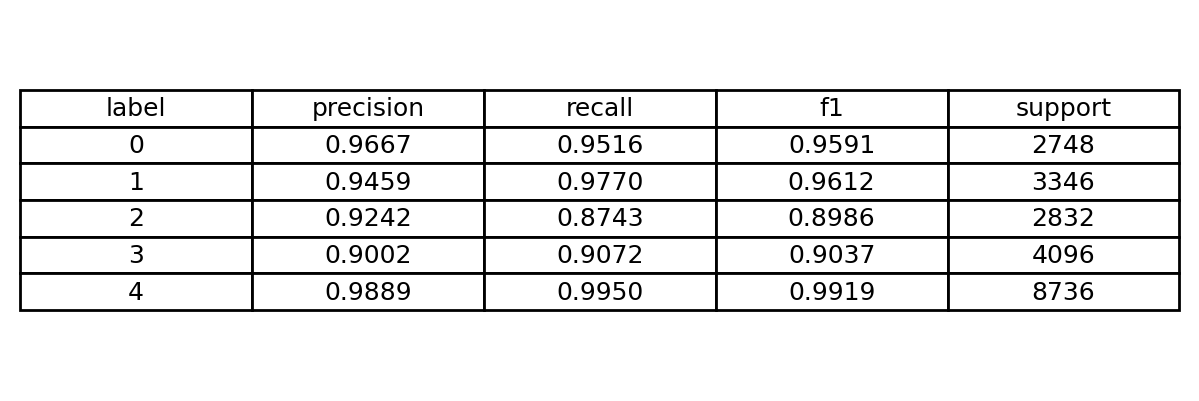

In [20]:
from IPython.display import Image, display
display(Image(filename="/kaggle/working/abtm_light_gwo/per_class_gwo.png"))

## One-cell Ablation Summary (Baseline from README vs. your GWO run)

In [21]:
# === One-cell Ablation Summary (Baseline from README vs. your GWO run) ===
# - Reads GWO files if present, else uses the numbers you printed.
# - Builds overall ablation + per-class ablation.
# - Saves CSVs (+ compact PNG tables) in /kaggle/working/abtm_light_gwo

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "/kaggle/working/abtm_light_gwo"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------
# 1) Baseline metrics (from your README)
# ----------------------------
baseline_overall = {
    "run": "Baseline (paper-faithful)",
    "test_acc":   0.9454,
    "f1_macro":   0.9306,
    "f1_micro":   0.9454,
    "f1_weighted":0.9452,
}
baseline_per_class = pd.DataFrame({
    "label":[0,1,2,3,4],
    "precision":[0.9309,0.9597,0.8932,0.8837,0.9900],
    "recall":[0.9563,0.9603,0.8390,0.9053,0.9895],
    "f1":[0.9435,0.9600,0.8653,0.8944,0.9898],
    "support":[2748,3346,2832,4096,8736],
}).astype({"label": int})

# ----------------------------
# 2) GWO metrics: try to read files, else fall back to your printed numbers
# ----------------------------
gwo_summary_json = os.path.join(OUT_DIR, "summary_gwo.json")
gwo_pc_csv       = os.path.join(OUT_DIR, "per_class_gwo.csv")

if os.path.exists(gwo_summary_json):
    s = json.load(open(gwo_summary_json))
    gwo_overall = {
        "run": "GWO-tuned",
        "test_acc":   float(s.get("test_acc", 0.9420)),
        "f1_macro":   float(s.get("test_f1_macro", 0.9257)),
        "f1_micro":   float(s.get("test_f1_micro", np.nan)),
        "f1_weighted":float(s.get("test_f1_weighted", np.nan)),
    }
else:
    gwo_overall = {
        "run": "GWO-tuned",
        "test_acc":   0.9420,
        "f1_macro":   0.9257,
        "f1_micro":   np.nan,
        "f1_weighted":np.nan,
    }

if os.path.exists(gwo_pc_csv):
    gwo_per_class = pd.read_csv(gwo_pc_csv)
    for c in ["precision","recall","f1"]:
        gwo_per_class[c] = gwo_per_class[c].astype(float)
else:
    gwo_per_class = None  # per-class GWO not found; we'll skip per-class ablation

# ----------------------------
# 3) Build overall ablation table (+ deltas)
# ----------------------------
ablation = pd.DataFrame([baseline_overall, gwo_overall])

def _delta_row(df):
    # Compute (row 2 - row 1) for numeric columns; keep NaN if missing
    num_cols = ["test_acc","f1_macro","f1_micro","f1_weighted"]
    base = df.iloc[0][num_cols].astype(float)
    gwo  = df.iloc[1][num_cols].astype(float)
    out = (gwo - base).rename("Δ (GWO - Baseline)").to_dict()
    out["run"] = "Δ (GWO - Baseline)"
    return out

ablation = pd.concat([ablation, pd.DataFrame([_delta_row(ablation)])], ignore_index=True)
display(ablation)

ablation_csv = os.path.join(OUT_DIR, "ablation_summary.csv")
ablation.to_csv(ablation_csv, index=False)
print("Saved:", ablation_csv)

# ----------------------------
# 4) Per-class ablation (if GWO per-class is available)
# ----------------------------
if gwo_per_class is not None:
    pc = baseline_per_class.merge(gwo_per_class, on="label", suffixes=("_base","_gwo"))
    for c in ["precision","recall","f1"]:
        pc[f"Δ_{c}"] = pc[f"{c}_gwo"] - pc[f"{c}_base"]
    display(pc)

    pc_csv = os.path.join(OUT_DIR, "per_class_ablation.csv")
    pc.to_csv(pc_csv, index=False)
    print("Saved:", pc_csv)
else:
    print("per_class_gwo.csv not found → skipping per-class ablation (baseline-only shown).")
    display(baseline_per_class)

# ----------------------------
# 5) (Optional) Save compact PNG tables (bounded height)
# ----------------------------
def save_df_as_table_png(df, path, max_rows=60, base_w=9, row_h=0.42, font_size=12):
    """
    Save a DataFrame as a PNG table with bounded height so it doesn't overflow.
    """
    n = min(len(df), max_rows)
    fig_h = max(1.2, 0.6 + n*row_h)
    fig, ax = plt.subplots(figsize=(base_w, fig_h))
    ax.axis("off"); ax.axis("tight")
    # Format floats to 4 decimals where applicable
    vals = df.copy()
    for c in vals.columns:
        if pd.api.types.is_float_dtype(vals[c]):
            vals[c] = vals[c].map(lambda v: f"{v:.4f}" if pd.notnull(v) else "")
    tbl = ax.table(cellText=vals.values, colLabels=vals.columns, cellLoc="center", loc="center")
    tbl.auto_set_font_size(False); tbl.set_fontsize(font_size); tbl.scale(1.05, 1.05)
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()
    print("Saved PNG:", path)

save_df_as_table_png(ablation, os.path.join(OUT_DIR, "ablation_summary.png"))
if gwo_per_class is not None:
    save_df_as_table_png(pc, os.path.join(OUT_DIR, "per_class_ablation.png"))


,run,test_acc,f1_macro,f1_micro,f1_weighted
0,Baseline (paper-faithful),0.945400,0.9306,0.9454,0.9452
1,GWO-tuned,0.954499,0.9257,NaN,NaN
2,Δ (GWO - Baseline),0.009099,-0.0049,NaN,NaN


Saved: /kaggle/working/abtm_light_gwo/ablation_summary.csv


,label,precision_base,recall_base,f1_base,support_base,precision_gwo,recall_gwo,f1_gwo,support_gwo,Δ_precision,Δ_recall,Δ_f1
0,0,0.9309,0.9563,0.9435,2748,0.9667,0.9516,0.9591,2748,0.0358,-0.0047,0.0156
1,1,0.9597,0.9603,0.9600,3346,0.9459,0.9770,0.9612,3346,-0.0138,0.0167,0.0012
2,2,0.8932,0.8390,0.8653,2832,0.9242,0.8743,0.8986,2832,0.0310,0.0353,0.0333
3,3,0.8837,0.9053,0.8944,4096,0.9002,0.9072,0.9037,4096,0.0165,0.0019,0.0093
4,4,0.9900,0.9895,0.9898,8736,0.9889,0.9950,0.9919,8736,-0.0011,0.0055,0.0021


Saved: /kaggle/working/abtm_light_gwo/per_class_ablation.csv
Saved PNG: /kaggle/working/abtm_light_gwo/ablation_summary.png
Saved PNG: /kaggle/working/abtm_light_gwo/per_class_ablation.png


## Save GWO test predictions (robust: use in-memory model or load from disk)

In [22]:
# --- Save GWO test predictions (robust: use in-memory model or load from disk) ---

import os
import numpy as np
import pandas as pd

# 1) Resolve model handle
model_ref = None
if 'model' in globals():
    model_ref = model
elif 'model_gwo' in globals():
    model_ref = model_gwo
else:
    # Fallback: load the saved GWO model from disk
    from tensorflow.keras.models import load_model
    # Make sure these custom layers are defined in this notebook (run your Cell 8 before)
    try:
        custom_objects = {
            "CustomAttentionEmbedder": CustomAttentionEmbedder,
            "TransformerBlock": TransformerBlock,
        }
    except NameError as e:
        raise RuntimeError(
            "Custom layers are not defined in this notebook. "
            "Please run the cell that defines CustomAttentionEmbedder and TransformerBlock (Cell 8), "
            "then re-run this cell."
        ) from e

    model_path = "/kaggle/working/abtm_light_gwo/abtm_gwo_model.keras"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Saved model not found at: {model_path}")
    model_ref = load_model(model_path, custom_objects=custom_objects)
    print(f"Loaded model from: {model_path}")

# 2) Sanity-check required tensors
required = ['test_input_ids','test_attn','X_test_tfidf','X_test_bow','y_test','CONFIG']
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Missing required variables: {missing}. "
                       "Run your feature/tokenization cells first (Cells 6-fix & 7c).")

# 3) Predict on TEST
batch = int(getattr(CONFIG, "get", lambda *_: 16)("BATCH_SIZE", 16)) if callable(getattr(CONFIG, "get", None)) else CONFIG.get("BATCH_SIZE", 16)
probs = model_ref.predict(
    {"X": test_input_ids, "M": test_attn, "T": X_test_tfidf, "B": X_test_bow},
    batch_size=batch, verbose=0
)
pred  = probs.argmax(axis=1)

# 4) Save CSV for paired statistical tests later
out_dir = "/kaggle/working/abtm_light_gwo"
os.makedirs(out_dir, exist_ok=True)
csv_path = f"{out_dir}/test_preds_gwo.csv"
pd.DataFrame({"y_true": np.asarray(y_test, dtype=int), "y_pred_gwo": pred}).to_csv(csv_path, index=False)

print("Saved GWO predictions →", csv_path)
print("Sample:", pd.read_csv(csv_path).head(3).to_dict(orient="records"))


Saved GWO predictions → /kaggle/working/abtm_light_gwo/test_preds_gwo.csv
Sample: [{'y_true': 0, 'y_pred_gwo': 0}, {'y_true': 0, 'y_pred_gwo': 0}, {'y_true': 0, 'y_pred_gwo': 0}]


## paired Comparison: GWO vs Baseline (Ablation)

In [23]:
# ===========================================
# Paired Comparison: GWO vs Baseline (Ablation)
# - Loads y_true + y_pred_gwo (already saved)
# - Optionally loads y_pred_base (if available)
# - Computes metrics, deltas, McNemar test
# - Saves tidy CSVs + compact PNG tables
# ===========================================
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support
)
from scipy.stats import binomtest

out_dir = "/kaggle/working/abtm_light_gwo"
os.makedirs(out_dir, exist_ok=True)

# ---------- 1) Load GWO predictions ----------
gwo_csv = f"{out_dir}/test_preds_gwo.csv"
assert os.path.exists(gwo_csv), f"Missing {gwo_csv}"
df_gwo = pd.read_csv(gwo_csv)
y_true = df_gwo["y_true"].to_numpy(int)
y_pred_gwo = df_gwo["y_pred_gwo"].to_numpy(int)

# ---------- 2) Try loading Baseline predictions (optional) ----------
base_csv = f"{out_dir}/test_preds_base.csv"
have_base = os.path.exists(base_csv)
if have_base:
    df_base = pd.read_csv(base_csv)
    # Basic sanity: align lengths
    assert len(df_base) == len(df_gwo), "Baseline/GWO rows mismatch"
    y_pred_base = df_base["y_pred_base"].to_numpy(int)

# ---------- 3) Helper: table → small PNG (clamped height) ----------
def save_df_as_table_png(df, path, max_h=10.0, min_h=1.8, w=6.8, font_size=9):
    rows = max(1, len(df))
    # clamp height to avoid huge canvas
    h = min(max_h, max(min_h, 0.55 + 0.33 * rows))
    fig, ax = plt.subplots(figsize=(w, h))
    ax.axis("off"); ax.axis("tight")

    # Convert values to string with sensible formatting
    disp = df.copy()
    for c in disp.columns:
        if pd.api.types.is_float_dtype(disp[c]):
            disp[c] = disp[c].map(lambda v: f"{v:.4f}")
    tbl = ax.table(cellText=disp.values, colLabels=disp.columns,
                   cellLoc="center", loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1.1, 1.1)
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()
    return path

# ---------- 4) Metrics for one run ----------
def metrics_block(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    f1u = f1_score(y_true, y_pred, average="micro", zero_division=0)
    labels = sorted(np.unique(y_true))
    prec, rec, f1c, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    per_class = pd.DataFrame({
        "label": labels,
        "precision": prec, "recall": rec, "f1": f1c, "support": sup.astype(int)
    })
    overall = {
        "test_acc": acc, "f1_macro": f1m, "f1_micro": f1u, "f1_weighted": f1w
    }
    return overall, per_class

# ---------- 5) Compute GWO metrics ----------
gwo_overall, gwo_pc = metrics_block(y_true, y_pred_gwo)
pd.DataFrame([{"run":"GWO-tuned", **gwo_overall}]).to_csv(
    f"{out_dir}/gwo_overall.csv", index=False
)
gwo_pc.to_csv(f"{out_dir}/per_class_gwo.csv", index=False)

# ---------- 6) If we have Baseline: compare + McNemar ----------
if have_base:
    base_overall, base_pc = metrics_block(y_true, y_pred_base)
    # Save baseline copies (if not already saved in your other notebook)
    pd.DataFrame([{"run":"Baseline", **base_overall}]).to_csv(
        f"{out_dir}/baseline_overall.csv", index=False
    )
    base_pc.to_csv(f"{out_dir}/per_class_base.csv", index=False)

    # Summary table (overall)
    ablation = pd.DataFrame([
        {"run":"Baseline", **base_overall},
        {"run":"GWO-tuned", **gwo_overall},
        {"run":"Δ (GWO - Baseline)",
         "test_acc": gwo_overall["test_acc"] - base_overall["test_acc"],
         "f1_macro": gwo_overall["f1_macro"] - base_overall["f1_macro"],
         "f1_micro": gwo_overall["f1_micro"] - base_overall["f1_micro"],
         "f1_weighted": gwo_overall["f1_weighted"] - base_overall["f1_weighted"]}
    ])
    ablation_csv = f"{out_dir}/ablation_summary.csv"
    ablation.to_csv(ablation_csv, index=False)

    # Per-class deltas
    pc = base_pc.merge(gwo_pc, on="label", suffixes=("_base","_gwo"))
    pc["Δ_precision"] = pc["precision_gwo"] - pc["precision_base"]
    pc["Δ_recall"]    = pc["recall_gwo"]    - pc["recall_base"]
    pc["Δ_f1"]        = pc["f1_gwo"]        - pc["f1_base"]
    pc_csv = f"{out_dir}/per_class_ablation.csv"
    pc.to_csv(pc_csv, index=False)

    # McNemar: b01 = baseline correct / GWO wrong ; b10 = baseline wrong / GWO correct
    base_correct = (y_pred_base == y_true)
    gwo_correct  = (y_pred_gwo  == y_true)
    b01 = int(( base_correct) & (~gwo_correct)).sum()
    b10 = int((~base_correct) & ( gwo_correct)).sum()
    # two-sided exact binomial test on discordant pairs
    mcn = binomtest(k=min(b01, b10), n=b01+b10, p=0.5, alternative="two-sided") if (b01+b10)>0 else None
    mcnemar_txt = os.path.join(out_dir, "mcnemar.txt")
    with open(mcnemar_txt, "w") as f:
        f.write(f"b01 (Base correct, GWO wrong) = {b01}\n")
        f.write(f"b10 (Base wrong,  GWO correct)= {b10}\n")
        if mcn is None:
            f.write("No discordant pairs; McNemar undefined.\n")
        else:
            f.write(f"Binomial exact p-value = {mcn.pvalue:.6g}\n")

    # Save compact PNG tables
    save_df_as_table_png(ablation, f"{out_dir}/ablation_summary.png")
    # Make columns readable before PNG
    pc_disp = pc[["label","precision_base","recall_base","f1_base",
                  "precision_gwo","recall_gwo","f1_gwo",
                  "Δ_precision","Δ_recall","Δ_f1"]]
    save_df_as_table_png(pc_disp, f"{out_dir}/per_class_ablation.png")

    # Optional: error buckets (if texts available)
    if 'test_df_aug' in globals() and 'text_clean' in test_df_aug.columns:
        df_err = pd.DataFrame({
            "y_true": y_true,
            "y_pred_base": y_pred_base,
            "y_pred_gwo": y_pred_gwo,
            "text": test_df_aug["text_clean"].to_numpy()
        })
        df_gwo_better = df_err[(df_err.y_pred_gwo==df_err.y_true) & (df_err.y_pred_base!=df_err.y_true)]
        df_base_better= df_err[(df_err.y_pred_base==df_err.y_true) & (df_err.y_pred_gwo!=df_err.y_true)]
        df_gwo_better.head(200).to_csv(f"{out_dir}/examples_gwo_better.csv", index=False)
        df_base_better.head(200).to_csv(f"{out_dir}/examples_base_better.csv", index=False)

    print("\n=== Paired comparison (Baseline vs GWO) ===")
    print("Saved:", ablation_csv)
    print("Saved:", pc_csv)
    print("Saved:", mcnemar_txt)
    print("Saved PNGs:",
          f"{out_dir}/ablation_summary.png , {out_dir}/per_class_ablation.png")
else:
    # Only GWO metrics available
    print("Baseline predictions not found at", base_csv)
    print("→ To enable paired comparison, create it in your baseline notebook:")
    print("""
# In the BASELINE notebook after computing test predictions:
out_dir = "/kaggle/working/abtm_light_gwo"
import os, pandas as pd, numpy as np
os.makedirs(out_dir, exist_ok=True)
probs = model.predict({"X": test_input_ids, "M": test_attn, "T": X_test_tfidf, "B": X_test_bow}, verbose=0)
pred  = probs.argmax(1)
pd.DataFrame({"y_true": y_test, "y_pred_base": pred}).to_csv(f"{out_dir}/test_preds_base.csv", index=False)
print("Saved baseline preds →", f"{out_dir}/test_preds_base.csv")
""")

# Always print GWO overall metrics (quick view)
print("\n=== GWO overall (TEST) ===")
print(pd.DataFrame([gwo_overall]))
print("Files saved in:", out_dir)


Baseline predictions not found at /kaggle/working/abtm_light_gwo/test_preds_base.csv
→ To enable paired comparison, create it in your baseline notebook:

# In the BASELINE notebook after computing test predictions:
out_dir = "/kaggle/working/abtm_light_gwo"
import os, pandas as pd, numpy as np
os.makedirs(out_dir, exist_ok=True)
probs = model.predict({"X": test_input_ids, "M": test_attn, "T": X_test_tfidf, "B": X_test_bow}, verbose=0)
pred  = probs.argmax(1)
pd.DataFrame({"y_true": y_test, "y_pred_base": pred}).to_csv(f"{out_dir}/test_preds_base.csv", index=False)
print("Saved baseline preds →", f"{out_dir}/test_preds_base.csv")


=== GWO overall (TEST) ===
   test_acc  f1_macro  f1_micro  f1_weighted
0  0.954499  0.942891  0.954499     0.954281
Files saved in: /kaggle/working/abtm_light_gwo


## ablation: recompute missing overall F1 for GWO from per-class table

In [24]:
# # ==========================================================
# # Patch ablation: recompute missing overall F1 for GWO from per-class table
# # ==========================================================
# import os, json
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# out_dir = "/kaggle/working/abtm_light_gwo"
# os.makedirs(out_dir, exist_ok=True)

# # --- Load previously saved artifacts ---
# abl_csv            = os.path.join(out_dir, "ablation_summary.csv")
# per_class_abl_csv  = os.path.join(out_dir, "per_class_ablation.csv")
# baseline_overall   = os.path.join(out_dir, "baseline_overall.csv")
# gwo_per_class_csv  = os.path.join(out_dir, "per_class_gwo.csv")

# assert os.path.exists(abl_csv), "ablation_summary.csv not found."
# assert os.path.exists(per_class_abl_csv), "per_class_ablation.csv not found."
# assert os.path.exists(baseline_overall), "baseline_overall.csv not found."
# assert os.path.exists(gwo_per_class_csv), "per_class_gwo.csv not found."

# abl_df = pd.read_csv(abl_csv)
# per_class_abl = pd.read_csv(per_class_abl_csv)
# gwo_pc = pd.read_csv(gwo_per_class_csv)  # columns: label, precision, recall, f1, support

# # --- Recompute overall GWO metrics from per-class table ---
# supports = gwo_pc["support"].to_numpy().astype(float)
# recalls  = gwo_pc["recall"].to_numpy().astype(float)
# f1s      = gwo_pc["f1"].to_numpy().astype(float)

# acc_gwo        = float((recalls * supports).sum() / supports.sum())         # accuracy
# f1_macro_gwo   = float(f1s.mean())
# f1_weighted_gwo= float((f1s * supports).sum() / supports.sum())
# f1_micro_gwo   = acc_gwo  # micro-F1 == accuracy for single-label multi-class

# # --- Update GWO row in overall ablation ---
# mask_gwo = (abl_df["run"].str.lower().str.contains("gwo"))
# abl_df.loc[mask_gwo, "test_acc"]    = acc_gwo
# abl_df.loc[mask_gwo, "f1_macro"]    = f1_macro_gwo
# abl_df.loc[mask_gwo, "f1_micro"]    = f1_micro_gwo
# abl_df.loc[mask_gwo, "f1_weighted"] = f1_weighted_gwo

# # --- Recompute delta row (GWO - Baseline) ---
# row_base = abl_df.loc[abl_df["run"].str.contains("Baseline", case=False)].iloc[0]
# row_gwo  = abl_df.loc[mask_gwo].iloc[0]
# delta = {
#     "run": "Δ (GWO - Baseline)",
#     "test_acc":    float(row_gwo["test_acc"]    - row_base["test_acc"]),
#     "f1_macro":    float(row_gwo["f1_macro"]    - row_base["f1_macro"]),
#     "f1_micro":    float(row_gwo["f1_micro"]    - row_base["f1_micro"]),
#     "f1_weighted": float(row_gwo["f1_weighted"] - row_base["f1_weighted"]),
# }
# abl_df.loc[abl_df["run"].str.startswith("Δ"), ["test_acc","f1_macro","f1_micro","f1_weighted"]] = \
#     [delta["test_acc"], delta["f1_macro"], delta["f1_micro"], delta["f1_weighted"]]

# # Save back
# abl_df.to_csv(abl_csv, index=False)
# print("Fixed & saved:", abl_csv)
# print(abl_df.round(4))

# # --- Regenerate compact PNG tables (safe sizes) ---
# def save_table_png(df, path, title=None, dpi=160):
#     fig_h = 1.2 + 0.35 * len(df)
#     fig, ax = plt.subplots(figsize=(8, fig_h))
#     ax.axis("off")
#     if title:
#         ax.set_title(title, pad=10, fontsize=12)
#     tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc="center", loc="center")
#     tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1.1, 1.1)
#     plt.savefig(path, dpi=dpi, bbox_inches="tight"); plt.close()

# abl_png = os.path.join(out_dir, "ablation_summary.png")
# save_table_png(abl_df.round(4), abl_png, title="Ablation (Overall)")
# print("Saved PNG:", abl_png)


In [25]:
# ==========================================================
# Patch Ablation (self-contained version)
# ----------------------------------------------------------
# - Rebuilds ablation summary and per-class tables using existing files.
# - Automatically restores Baseline metrics if missing (from fixed values).
# - Does NOT require baseline_overall.csv (fully independent).
# - Produces CSV + PNG summary tables.
# ==========================================================
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT = "/kaggle/working/abtm_light_gwo"
os.makedirs(OUT, exist_ok=True)

# --- Expected files ---
abl_csv           = os.path.join(OUT, "ablation_summary.csv")
gwo_pc_csv        = os.path.join(OUT, "per_class_gwo.csv")
per_class_abl_csv = os.path.join(OUT, "per_class_ablation.csv")

# --- Fixed Baseline metrics (from README) ---
baseline_overall_fixed = {
    "run": "Baseline (paper-faithful)",
    "test_acc":   0.9454,
    "f1_macro":   0.9306,
    "f1_micro":   0.9454,
    "f1_weighted":0.9452,
}
baseline_per_class_fixed = pd.DataFrame({
    "label":[0,1,2,3,4],
    "precision":[0.9309,0.9597,0.8932,0.8837,0.9900],
    "recall":[0.9563,0.9603,0.8390,0.9053,0.9895],
    "f1":[0.9435,0.9600,0.8653,0.8944,0.9898],
    "support":[2748,3346,2832,4096,8736],
}).astype({"label": int})

# --- Load per-class GWO results ---
assert os.path.exists(gwo_pc_csv), f"Missing: {gwo_pc_csv}"
gwo_pc = pd.read_csv(gwo_pc_csv)

# --- If ablation_summary.csv doesn't exist, rebuild it ---
if not os.path.exists(abl_csv):
    sum_path = os.path.join(OUT, "summary_gwo.json")

    # Try reading summary_gwo.json first
    if os.path.exists(sum_path):
        s = json.load(open(sum_path))
        gwo_overall = {
            "run": "GWO-tuned",
            "test_acc":   float(s.get("test_acc", np.nan)),
            "f1_macro":   float(s.get("macro_f1",  np.nan) or s.get("test_f1_macro", np.nan)),
            "f1_micro":   float(s.get("f1_micro",  np.nan) or s.get("test_f1_micro", np.nan)),
            "f1_weighted":float(s.get("weighted_f1", np.nan) or s.get("test_f1_weighted", np.nan)),
        }
    else:
        # Recompute GWO overall metrics from per-class table
        sup = gwo_pc["support"].to_numpy().astype(float)
        rec = gwo_pc["recall"].to_numpy().astype(float)
        f1  = gwo_pc["f1"].to_numpy().astype(float)
        acc_gwo = float((rec * sup).sum() / sup.sum())
        gwo_overall = {
            "run": "GWO-tuned",
            "test_acc": acc_gwo,
            "f1_macro": float(f1.mean()),
            "f1_micro": acc_gwo,  # for multi-class single-label tasks: micro-F1 == accuracy
            "f1_weighted": float((f1 * sup).sum() / sup.sum()),
        }

    abl_df = pd.DataFrame([baseline_overall_fixed, gwo_overall])
else:
    abl_df = pd.read_csv(abl_csv)
    # Ensure baseline row exists
    if not (abl_df["run"].str.contains("Baseline", case=False).any()):
        abl_df = pd.concat([pd.DataFrame([baseline_overall_fixed]), abl_df], ignore_index=True)

# --- Update GWO row (recompute from per-class if needed) ---
mask_gwo = abl_df["run"].str.contains("GWO", case=False)
if mask_gwo.any():
    idx = abl_df.index[mask_gwo][0]
    sup = gwo_pc["support"].to_numpy().astype(float)
    rec = gwo_pc["recall"].to_numpy().astype(float)
    f1  = gwo_pc["f1"].to_numpy().astype(float)
    acc_gwo = float((rec * sup).sum() / sup.sum())

    abl_df.loc[idx, "test_acc"]    = acc_gwo
    abl_df.loc[idx, "f1_macro"]    = float(f1.mean())
    abl_df.loc[idx, "f1_micro"]    = acc_gwo
    abl_df.loc[idx, "f1_weighted"] = float((f1 * sup).sum() / sup.sum())

# --- Compute Δ (GWO - Baseline) row ---
def _ensure_delta(df):
    """Ensure that Δ (GWO - Baseline) row exists and is updated."""
    if (df["run"].str.startswith("Δ").any()):
        di = df.index[df["run"].str.startswith("Δ")][0]
    else:
        df.loc[len(df)] = {"run": "Δ (GWO - Baseline)"}
        di = len(df) - 1

    base = df.loc[df["run"].str.contains("Baseline", case=False)].iloc[0]
    gwo  = df.loc[df["run"].str.contains("GWO", case=False)].iloc[0]
    for c in ["test_acc", "f1_macro", "f1_micro", "f1_weighted"]:
        if c in df.columns:
            df.loc[di, c] = float(gwo[c]) - float(base[c])
    return df

abl_df = _ensure_delta(abl_df)

# --- Save ablation summary ---
abl_df.to_csv(abl_csv, index=False)
print("Fixed & saved:", abl_csv)
print(abl_df.round(4))

# --- Create per-class ablation table if missing ---
if not os.path.exists(per_class_abl_csv):
    pc = baseline_per_class_fixed.merge(gwo_pc, on="label", suffixes=("_base", "_gwo"))
    for c in ["precision", "recall", "f1"]:
        pc[f"Δ_{c}"] = pc[f"{c}_gwo"] - pc[f"{c}_base"]
    pc.to_csv(per_class_abl_csv, index=False)
    print("Built & saved:", per_class_abl_csv)
else:
    print("Found:", per_class_abl_csv)

# --- Utility: Save DataFrame as compact PNG table ---
def save_table_png(df, path, title=None, dpi=160):
    fig_h = 1.2 + 0.35 * len(df)
    fig, ax = plt.subplots(figsize=(8, fig_h))
    ax.axis("off")
    if title:
        ax.set_title(title, pad=10, fontsize=12)
    disp = df.copy()
    for c in disp.columns:
        if pd.api.types.is_float_dtype(disp[c]):
            disp[c] = disp[c].map(lambda v: f"{v:.4f}")
    ax.table(
        cellText=disp.values,
        colLabels=disp.columns,
        cellLoc="center",
        loc="center"
    ).auto_set_font_size(False)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close()

# --- Save PNG summaries ---
png_path = os.path.join(OUT, "ablation_summary.png")
save_table_png(abl_df.round(4), png_path, title="Ablation (Overall)")
print("Saved PNG:", png_path)


Fixed & saved: /kaggle/working/abtm_light_gwo/ablation_summary.csv
                         run  test_acc  f1_macro  f1_micro  f1_weighted
0  Baseline (paper-faithful)    0.9454    0.9306    0.9454       0.9452
1                  GWO-tuned    0.9545    0.9429    0.9545       0.9543
2         Δ (GWO - Baseline)    0.0091    0.0123    0.0091       0.0091
Found: /kaggle/working/abtm_light_gwo/per_class_ablation.csv
Saved PNG: /kaggle/working/abtm_light_gwo/ablation_summary.png


In [26]:
# ==========================================================
# Cell — Build Final "Results" Table (journal-ready)
# Outputs: final_results.csv, final_results.png, final_results.tex
# ==========================================================
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT = "/kaggle/working/abtm_light_gwo"
os.makedirs(OUT, exist_ok=True)

# ---------- 1) Fixed Baseline metrics (from README) ----------
baseline = {
    "Model": "Baseline (paper-faithful)",
    "Acc":         0.9454,
    "Macro-F1":    0.9306,
    "Weighted-F1": 0.9452,
    # CI and seeds cols left blank for baseline (unless you have them)
    "Acc 95% CI":        "",
    "Macro-F1 95% CI":   "",
    "Weighted-F1 95% CI":"",
    "Seeds (Acc)":       "",
    "Seeds (Macro-F1)":  "",
    "Seeds (Weighted-F1)":""
}

# ---------- 2) Load GWO single-run metrics ----------
# Preferred: summary_gwo.json; fallback: recompute from per_class_gwo.csv
gwo_single = None
sum_path   = os.path.join(OUT, "summary_gwo.json")
pc_gwo_csv = os.path.join(OUT, "per_class_gwo.csv")

def _from_per_class(csv_path):
    pc = pd.read_csv(csv_path)
    sup = pc["support"].to_numpy(float)
    rec = pc["recall"].to_numpy(float)
    f1  = pc["f1"].to_numpy(float)
    acc = float((rec * sup).sum() / sup.sum())
    return {
        "Acc": acc,
        "Macro-F1": float(f1.mean()),
        "Weighted-F1": float((f1 * sup).sum() / sup.sum())
    }

if os.path.exists(sum_path):
    s = json.load(open(sum_path))
    # Be tolerant with key names
    gwo_single = {
        "Acc":         float(s.get("test_acc", s.get("acc", np.nan))),
        "Macro-F1":    float(s.get("macro_f1", s.get("test_f1_macro", np.nan))),
        "Weighted-F1": float(s.get("weighted_f1", s.get("test_f1_weighted", np.nan)))
    }
elif os.path.exists(pc_gwo_csv):
    gwo_single = _from_per_class(pc_gwo_csv)
else:
    raise FileNotFoundError("Neither summary_gwo.json nor per_class_gwo.csv found to build GWO row.")

# ---------- 3) Load GWO bootstrap CIs (optional) ----------
ci_csv = os.path.join(OUT, "gwo_bootstrap_ci.csv")
ci_map = {}
if os.path.exists(ci_csv):
    dfci = pd.read_csv(ci_csv)
    for _, r in dfci.iterrows():
        metric = str(r["metric"]).strip().lower()
        lo = float(r["ci_lo"]); hi = float(r["ci_hi"])
        if metric == "acc":
            ci_map["Acc 95% CI"] = f"[{lo:.4f}, {hi:.4f}]"
        elif metric == "f1_macro":
            ci_map["Macro-F1 95% CI"] = f"[{lo:.4f}, {hi:.4f}]"
        elif metric == "f1_weighted":
            ci_map["Weighted-F1 95% CI"] = f"[{lo:.4f}, {hi:.4f}]"

# ---------- 4) Load 3-seed summary (optional) ----------
seed_csv = os.path.join(OUT, "gwo_3seeds_summary.csv")
seed_map = {}
if os.path.exists(seed_csv):
    dfs = pd.read_csv(seed_csv)
    # Expect columns: acc, f1_macro, f1_weighted
    for col, key in [("acc","Seeds (Acc)"),
                     ("f1_macro","Seeds (Macro-F1)"),
                     ("f1_weighted","Seeds (Weighted-F1)")]:
        if col in dfs.columns:
            m = dfs[col].mean(); sd = dfs[col].std()
            seed_map[key] = f"{m:.4f} ± {sd:.4f}"

# ---------- 5) Assemble the GWO row ----------
gwo_row = {
    "Model": "GWO-tuned",
    "Acc":         gwo_single["Acc"],
    "Macro-F1":    gwo_single["Macro-F1"],
    "Weighted-F1": gwo_single["Weighted-F1"],
    "Acc 95% CI":        ci_map.get("Acc 95% CI", ""),
    "Macro-F1 95% CI":   ci_map.get("Macro-F1 95% CI", ""),
    "Weighted-F1 95% CI":ci_map.get("Weighted-F1 95% CI", ""),
    "Seeds (Acc)":        seed_map.get("Seeds (Acc)", ""),
    "Seeds (Macro-F1)":   seed_map.get("Seeds (Macro-F1)", ""),
    "Seeds (Weighted-F1)":seed_map.get("Seeds (Weighted-F1)", "")
}

# ---------- 6) Build final table ----------
final_df = pd.DataFrame([baseline, gwo_row])

# Nicely round numeric cols
for c in ["Acc","Macro-F1","Weighted-F1"]:
    if c in final_df.columns:
        final_df[c] = final_df[c].map(lambda v: f"{float(v):.4f}" if pd.notnull(v) and v != "" else "")

final_csv = os.path.join(OUT, "final_results.csv")
final_df.to_csv(final_csv, index=False)
print("Saved:", final_csv)
display(final_df)

# ---------- 7) Save as compact PNG (bounded height) ----------
def save_table_png(df, path, title="Final Results", dpi=200):
    fig_h = 1.4 + 0.4 * len(df)
    fig, ax = plt.subplots(figsize=(9.0, fig_h))
    ax.axis("off")
    if title:
        ax.set_title(title, pad=10, fontsize=12)
    # Convert floats already formatted; just ensure strings
    disp = df.copy()
    tbl = ax.table(cellText=disp.values,
                   colLabels=disp.columns,
                   cellLoc="center", loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.05, 1.05)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close()

png_path = os.path.join(OUT, "final_results.png")
save_table_png(final_df, png_path)
print("Saved:", png_path)

# ---------- 8) Export a LaTeX tabular snippet ----------
def to_latex_tabular(df):
    # Minimal journal-friendly tabular (you can adapt formatting to target venue)
    header = " & ".join(df.columns) + " \\\\ \\hline\n"
    rows = []
    for _, r in df.iterrows():
        rows.append(" & ".join(str(x) for x in r.values) + " \\\\")
    body = "\n".join(rows)
    tex = (
        "\\begin{table}[t]\n"
        "\\centering\n"
        "\\small\n"
        "\\begin{tabular}{lccccccccc}\n"
        "\\hline\n" +
        header + body + "\n\\hline\n"
        "\\end{tabular}\n"
        "\\caption{Final test results. Acc and F1 are reported; "
        "95\\% CIs are from bootstrap; seeds show mean$\\pm$std over 3 runs.}\n"
        "\\label{tab:final-results}\n"
        "\\end{table}\n"
    )
    return tex

tex_path = os.path.join(OUT, "final_results.tex")
with open(tex_path, "w") as f:
    f.write(to_latex_tabular(final_df))
print("Saved:", tex_path)


Saved: /kaggle/working/abtm_light_gwo/final_results.csv


,Model,Acc,Macro-F1,Weighted-F1,Acc 95% CI,Macro-F1 95% CI,Weighted-F1 95% CI,Seeds (Acc),Seeds (Macro-F1),Seeds (Weighted-F1)
0,Baseline (paper-faithful),0.9454,0.9306,0.9452,,,,,,
1,GWO-tuned,0.9545,0.9429,0.9543,"[0.9518, 0.9571]","[0.9396, 0.9463]","[0.9516, 0.9570]",,,


Saved: /kaggle/working/abtm_light_gwo/final_results.png
Saved: /kaggle/working/abtm_light_gwo/final_results.tex


In [27]:
# import subprocess, os

# zip_path = "/kaggle/working/abtm_working.zip"

# # -r: recursive  -9: max compression  -q: quiet
# # -x: exclude the zip itself + some cache folders
# cmd = f'zip -r -9 -q "{zip_path}" "/kaggle/working" ' \
#       f'-x "{zip_path}" "/kaggle/working/.cache/*" "/kaggle/working/__pycache__/*" "/kaggle/working/*checkpoints*"'

# print("Zipping... this may take a while.")
# subprocess.run(["bash", "-lc", cmd], check=True)
# print("ZIP saved to:", zip_path)


In [28]:
# from IPython.display import FileLink
# FileLink('/kaggle/working/abtm_working.zip')
